In [1]:
from graph_generation.generate_graph import generate_erdos_renyi_graph, generate_erdos_renyi_attribute_graph
from graph_generation.generate_graph import generate_barabasi_albert_graph,generate_barabasi_albert_attribute_graph, generate_random_tree_graph
from graph_generation.generate_graph import generate_forest_fire_graph, generate_forest_fire_attribute_graph, generate_balanced_tree_graph
from diffusion_models.edge_probabilities import generate_edge_probabilities
from diffusion_models.independent_cascade import independent_cascade, optimized_independent_cascade, dmp_ic, dynamic_message_passing, ALE_heuristic, monte_carlo_ic, modified_ALE, simulate_multiplicative_path_survival, ALE_heuristic_transpose, IC_approx, message_passing, compute_p0_p1_p2, IC_approx_vectorized, IC_approx_vectorized_torch
from influence_maximization.im import im_ic, im_diff
from training.train_gnn import train_gnn
from training.train_edge_gnn import train_diffusion_pipeline, train_diffusion_gnn, train_edge_model_with_diffusion, train_diffusion_multiple, train_edge_model
import numpy as np
import networkx as nx
import torch
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
from models.gnn_model import LearnableDiffusionGNN, MultiplicativeDiffusionGNN, StructureAwareEdgeGNN, EdgeGNN, EdgeGAT, simpleEdgePrediction, simpleEdgePrediction2, GCNMultiplicativeDiffusionGNN, ALE, ModifiedALE, ICApproxLayer, InfluenceSpreadNN, ICApproxLossModule
from models.edge_gnn_models import GraphEdgeModel
from plotting_tools.prob_plots import posterior_plots, edge_plots
import torch.nn.functional as F
from training.genetic_edge_training import run_ga_training, evaluate_on_test_graph
import time
size_x=10
size_y=3.5

def edge_index_to_dict(edge_index, edge_probs):
    src = edge_index[0].tolist()
    dst = edge_index[1].tolist()
    edges = list(zip(src, dst))
    edge_dict = {edge: edge_probs[i] for i, edge in enumerate(edges)}  # use tensor elements
    return edge_dict

# Difussion for random edge weights

Test RMSE Loss: 0.0987
Org RMSE Loss: 0.0991


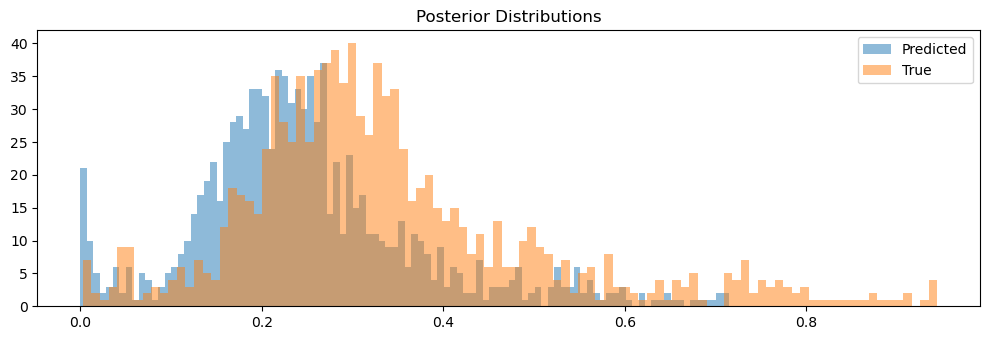

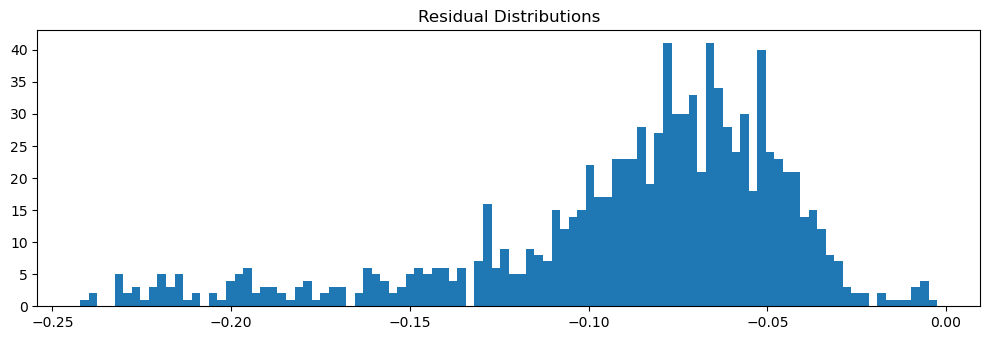

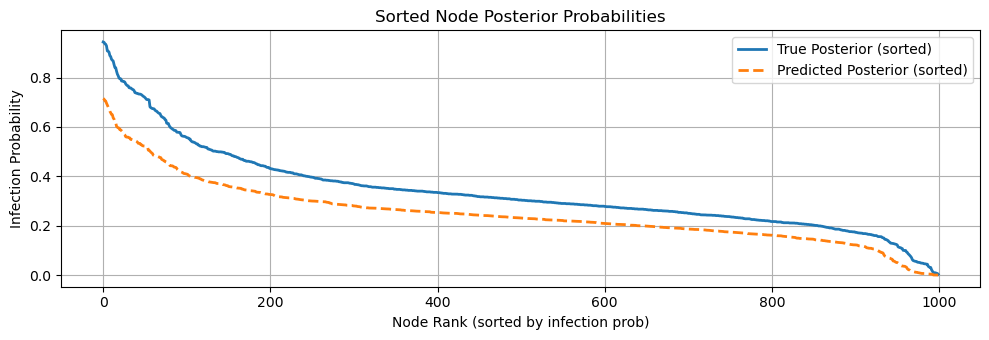

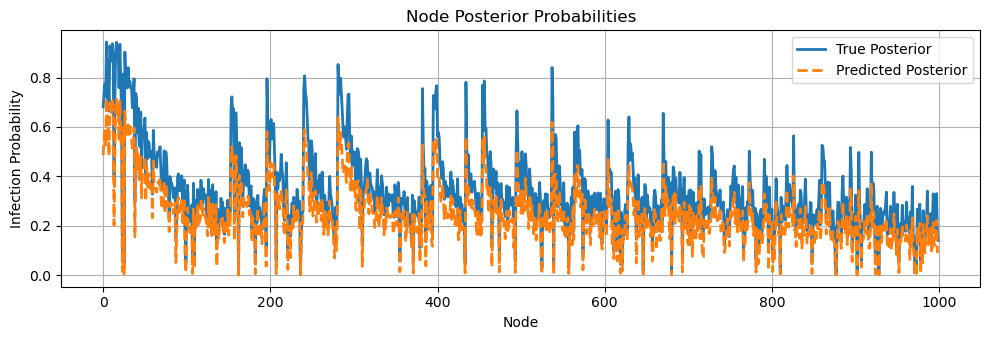

ROC threshold for 50-percentil is 0.30399999022483826


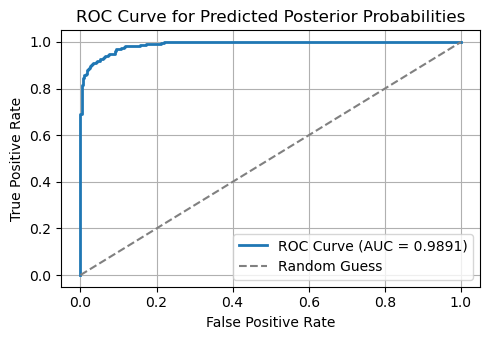

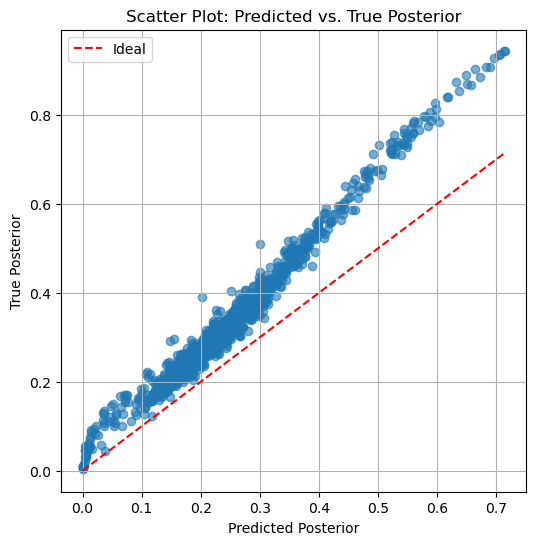

The Pearson correlation:  tensor(0.9896)
The Spearman correlation:  0.9833827388999462


'posterior_plots(size_x,\n                size_y,\n                predicted_posterior_org-prior_probs_test.unsqueeze(1),\n                true_posterior_tensor_org-prior_probs_test.unsqueeze(1),\n                percentile=50)'

In [69]:
num_nodes=1000
edge_prob=0.0025
num_edges_per_node=10
prob_selected = 0.1
model_to_use="ICApproxLayer"
method="random"
num_graphs=1
num_sim=1000
dropout=0.05
r=4
h=5
low=0
high=1/num_edges_per_node

data_list = []
for _ in range(num_graphs):
    #G, prior_probs = generate_erdos_renyi_graph(num_nodes, edge_prob, prob_selected = 0.1)
    G, prior_probs = generate_barabasi_albert_graph(num_nodes, num_edges_per_node, prob_selected = prob_selected)
    #G, prior_probs = generate_balanced_tree_graph(r, h, prob_selected = 0.3)
    #G, prior_probs = generate_random_tree_graph(num_nodes, prob_selected = 0.3)
    #G, prior_probs = generate_forest_fire_graph(num_nodes, fw_prob=0.37, bw_factor=0.32, ambs=1, prob_selected=0.3)
    
    '''edges = list(G.edges())
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_dict = generate_edge_probabilities(G,method=method,c=1,low=low, high=high)
    edge_attr = torch.tensor([edge_dict[(u, v)] for (u, v) in edges], dtype=torch.float)'''

    edge_dict = generate_edge_probabilities(G,method=method,c=1,low=low, high=high, p=0.1)
    edges = list(edge_dict.keys())  # or better: edges = your edge_index list directly
    edge_index = torch.tensor(edges, dtype=torch.long).T  # shape (2, num_edges)
    edge_probs = torch.tensor([edge_dict[(u, v)] for (u, v) in edges], dtype=torch.float)
    
    data = Data(x=prior_probs.unsqueeze(1), edge_index=edge_index, edge_attr=edge_probs)
    data_list.append(data)

'''trained_model = train_diffusion_multiple(data_list,
                                    optimized_independent_cascade,
                                    num_steps=10,
                                    epochs=700,
                                    lr=0.015,
                                    use_difference=False,
                                    model_to_use=model_to_use,
                                    num_sim=num_sim)'''

#test data
#G_test, prior_probs_test = generate_erdos_renyi_graph(num_nodes, edge_prob, prob_selected = 0.3)
G_test, prior_probs_test = generate_barabasi_albert_graph(num_nodes, num_edges_per_node, prob_selected = prob_selected)
#G_test, prior_probs_test = generate_balanced_tree_graph(r, h, prob_selected = 0.3)
#G_test, prior_probs_test = generate_random_tree_graph(num_nodes, prob_selected = 0.3)
#G_test, prior_probs_test = generate_forest_fire_graph(num_nodes, fw_prob=0.37, bw_factor=0.32, ambs=1, prob_selected=0.3)

'''edge_dict_t = generate_edge_probabilities(G_test,method=method,c=1, low=low, high=high)
edges_t = list(G_test.edges())
edge_index_t = torch.tensor(edges_t, dtype=torch.long).t().contiguous()
edge_attr_t = torch.tensor([edge_dict_t[(u, v)] for (u, v) in edges_t], dtype=torch.float)'''

edge_dict_t = generate_edge_probabilities(G_test,method=method,c=1, low=low, high=high, p=0.1)
edges_t = list(edge_dict_t.keys())  # or better: edges = your edge_index list directly
edge_index_t = torch.tensor(edges_t, dtype=torch.long).T  # shape (2, num_edges)
edge_probs_t = torch.tensor([edge_dict_t[(u, v)] for (u, v) in edges_t], dtype=torch.float)

'''trained_model = train_diffusion_gnn(data_list[0],
                                    optimized_independent_cascade,
                                    num_steps=5,
                                    epochs=500,
                                    lr=0.001,
                                    use_difference=False,
                                    model_to_use=model_to_use,
                                    alpha=1,
                                    alpha1=0, 
                                    alpha2=0,
                                    BCE=False,
                                    dropout=dropout)'''

data_t = Data(x=prior_probs_test.unsqueeze(1), edge_index=edge_index_t, edge_attr=edge_probs_t)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#trained_model = ICApproxLayer(num_steps=10,num_nodes=num_nodes).to(device)
#trained_model = InfluenceSpreadNN(num_steps=10).to(device)
trained_model = ICApproxLossModule().to(device)
#trained_model_test = ICApproxLossModule(G_test, edge_dict_t, 10).to(device)
trained_model.eval()
with torch.no_grad():
    #G, prior_probs, edge_index, edge_probs, k
    predicted_posterior_org = trained_model(G, prior_probs, edge_index, edge_probs, 5).unsqueeze(1)
    predicted_posterior = trained_model(G_test, prior_probs_test, edge_index_t, edge_probs_t, 5).unsqueeze(1)
    #predicted_posterior = trained_model_test(prior_probs_test).unsqueeze(1)
    #predicted_posterior_org = trained_model(prior_probs, edge_index, edge_probs).unsqueeze(0)
    #predicted_posterior = trained_model(prior_probs_test, edge_index_t, edge_probs_t)

# Compare predicted_posterior with true_posterior
ic = optimized_independent_cascade(G_test, prior_probs_test, edge_dict_t, num_sim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
true_posterior_tensor = torch.tensor(
    [ic[node] for node in ic],
    dtype=torch.float,
    device=device
).view(-1, 1)

ic_org = optimized_independent_cascade(G, prior_probs, edge_dict, num_sim)
true_posterior_tensor_org = torch.tensor(
    [ic_org[node] for node in ic_org],
    dtype=torch.float,
    device=device
).view(-1, 1)

rmse_loss = torch.nn.MSELoss()(predicted_posterior, true_posterior_tensor)
print(f"Test RMSE Loss: {rmse_loss.item()**0.5:.4f}")

rmse_loss_org = torch.nn.MSELoss()(predicted_posterior_org, true_posterior_tensor_org)
print(f"Org RMSE Loss: {rmse_loss_org.item()**0.5:.4f}")

posterior_plots(size_x,
                size_y,
                predicted_posterior-prior_probs_test.unsqueeze(1),
                true_posterior_tensor-prior_probs_test.unsqueeze(1),
                percentile=50)
'''posterior_plots(size_x,
                size_y,
                predicted_posterior_org-prior_probs_test.unsqueeze(1),
                true_posterior_tensor_org-prior_probs_test.unsqueeze(1),
                percentile=50)'''

In [24]:
print(true_posterior_tensor.mean())
print(true_posterior_tensor.max())
print(true_posterior_tensor.min())
print(true_posterior_tensor.std())
print()
print(true_posterior_tensor_t.mean())
print(true_posterior_tensor_t.max())
print(true_posterior_tensor_t.min())
print(true_posterior_tensor_t.std())

tensor(0.4088)
tensor(1.)
tensor(0.0470)
tensor(0.2091)

tensor(0.3910)
tensor(0.9960)
tensor(0.0860)
tensor(0.1670)


In [11]:
true_posterior_tensor.size()

torch.Size([1000, 1])

In [5]:
prior_probs

tensor([0.0000, 0.8161, 0.7882, 0.0000, 0.2083])

In [10]:
node = 0
sum = 0
for v in G_test.predecessors(node):
    sum += edge_dict_t[(v,node)]*prior_probs_test[v]
print(sum)

tensor(4.3715)


In [3]:
#(((predicted_posterior-true_posterior_tensor)**2).mean())**0.5
#predicted_posterior.shape
#preds_IC_approx.shape
#edge_dict
#edge_probs
# NumPy output
out_np = IC_approx_vectorized(G_test, edge_dict_t, prior_probs_test, k=1, use_cond=False, par=1.0)

# PyTorch model
model = ICApproxLayer(num_steps=1, num_nodes=num_nodes, use_cond=False, par=1.0)
out_torch = model(prior_probs_test, edge_index_t, edge_probs_t).view(-1).detach().cpu().numpy()

# Compare
diff = np.abs(out_np - out_torch)
print("Max diff:", diff.max())
print("Mean diff:", diff.mean())
out_np

Max diff: 0.28959469024989914
Mean diff: 0.033263758757050475


array([3.30318203e-01, 2.01490935e-01, 4.28963546e-03, 4.34699848e-01,
       5.78332056e-02, 2.62291298e-01, 1.79893817e-01, 2.55455051e-01,
       3.17547387e-02, 1.33950607e-01, 1.22461032e-02, 9.01985629e-02,
       8.07295510e-02, 2.79197642e-01, 4.75386959e-02, 1.84161766e-01,
       4.45213011e-02, 9.87310959e-04, 1.80891885e-01, 3.87336693e-01,
       1.88150995e-01, 2.79859755e-02, 1.53879016e-02, 1.82832690e-01,
       7.41169070e-02, 7.84674326e-02, 4.59637216e-02, 1.28643987e-01,
       7.33992312e-02, 1.23282063e-01, 1.25357033e-01, 1.01675828e-01,
       6.33622320e-02, 3.34808605e-02, 3.62501969e-01, 6.14865076e-02,
       8.00095620e-03, 4.89190923e-02, 2.75195487e-02, 1.98099874e-02,
       9.90305504e-02, 7.56362702e-02, 5.57582791e-02, 1.62578652e-01,
       4.09475268e-02, 5.37082419e-02, 1.08285006e-02, 3.99518453e-02,
       1.00980167e-02, 6.84481715e-02, 6.99244999e-02, 1.99964956e-02,
       8.09742093e-03, 5.55987231e-02, 6.62589281e-02, 1.32851084e-02,
      

In [4]:
for i in range(edge_index.size(1)):
    u = edge_index[0, i].item()
    v = edge_index[1, i].item()
    if not ((edge_index[0] == v) & (edge_index[1] == u)).any():
        print(f"Missing reverse edge for ({u}, {v})")

## ALE

/home/matic/Documents/IMreasearch/py_scripts/diffusion_models/independent_cascade.py:311: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_p_list = []


Runtime: 0.022404 seconds
ALE Test RMSE Loss: 0.1782


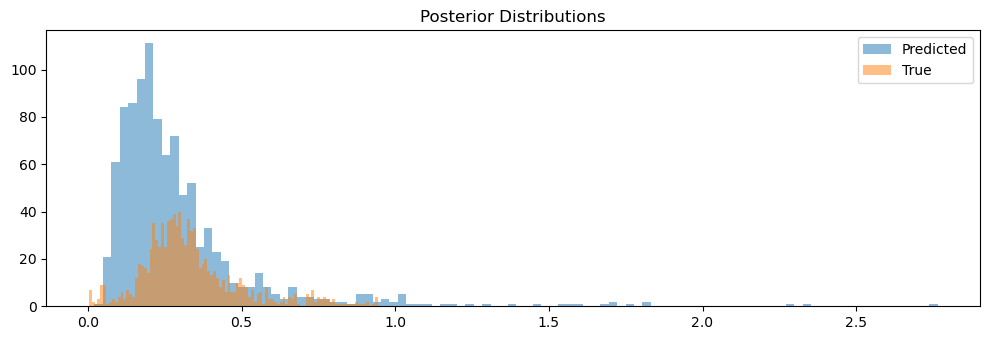

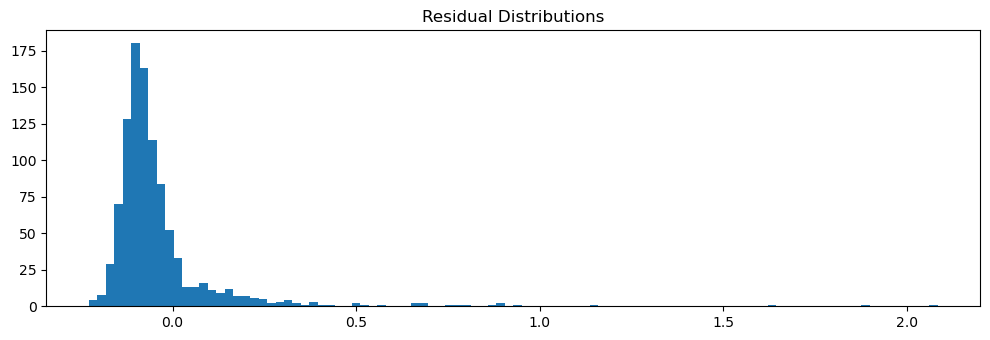

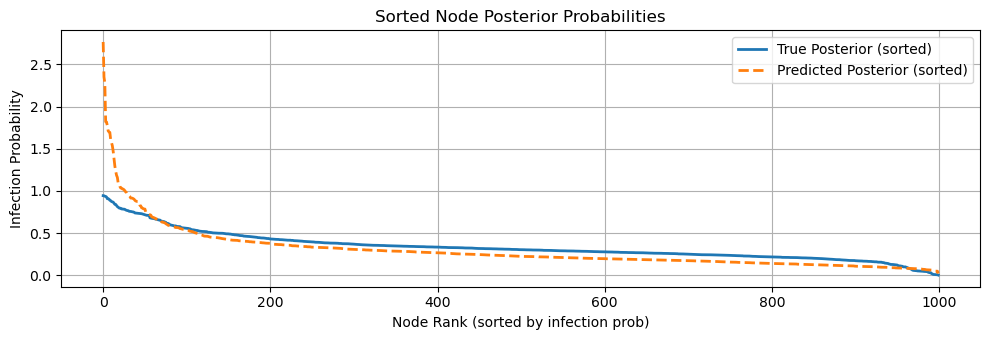

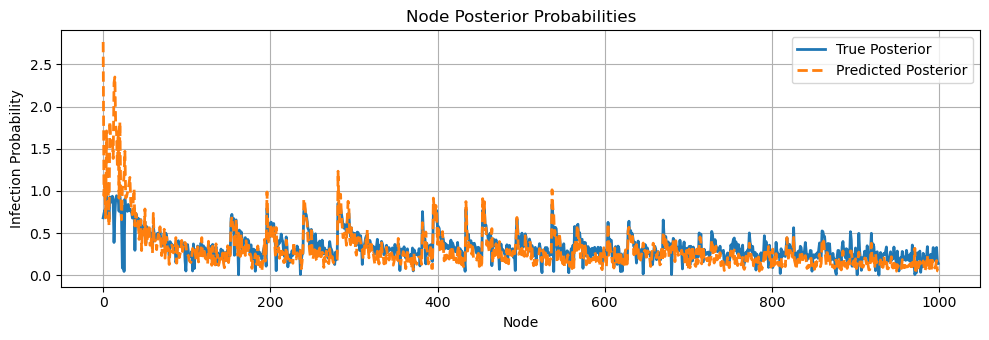

ROC threshold for 50-percentil is 0.30399999022483826


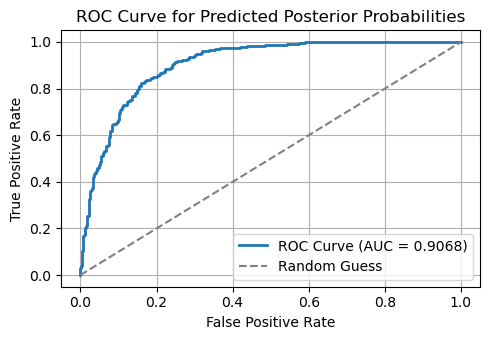

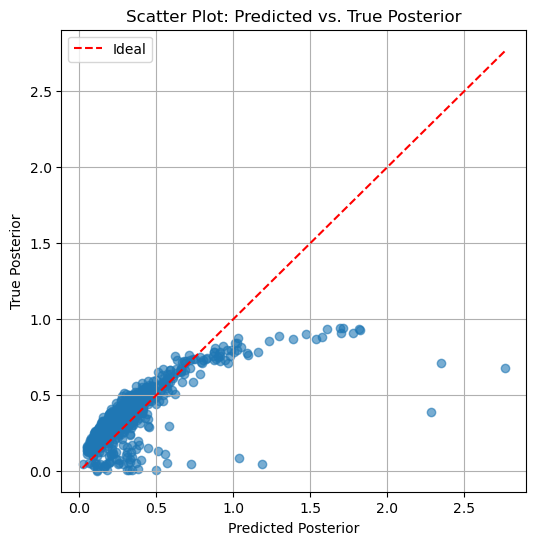

The Pearson correlation:  tensor(0.7685)
The Spearman correlation:  0.7914317793587592


In [71]:


start = time.time()
preds_ale = ALE_heuristic(G_test, prior_probs_test,edge_dict_t,4).unsqueeze(1)
end = time.time()
print(f"Runtime: {end - start:.6f} seconds")
rmse_loss_ale = torch.nn.MSELoss()(preds_ale, true_posterior_tensor)
print(f"ALE Test RMSE Loss: {rmse_loss_ale.item()**0.5:.4f}")
posterior_plots(size_x,
                size_y,
                preds_ale-prior_probs_test.unsqueeze(1),
                true_posterior_tensor-prior_probs_test.unsqueeze(1))

## Modified ALE

/home/matic/Documents/IMreasearch/py_scripts/diffusion_models/independent_cascade.py:495: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_p_list = []


Runtime: 0.021412 seconds
ALE Test RMSE Loss: 0.0822


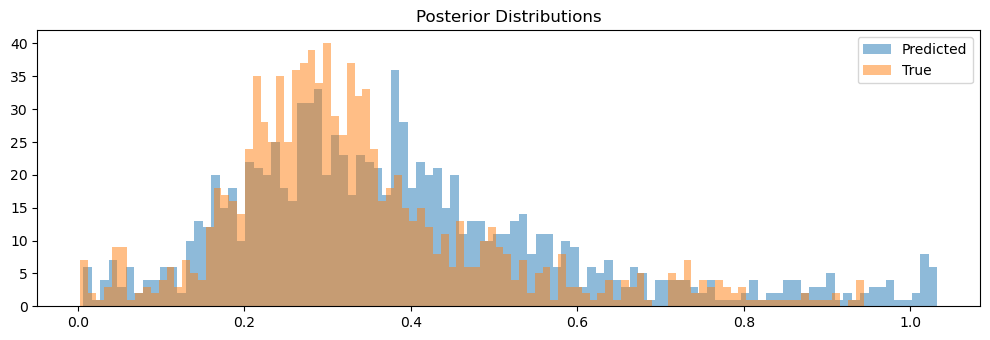

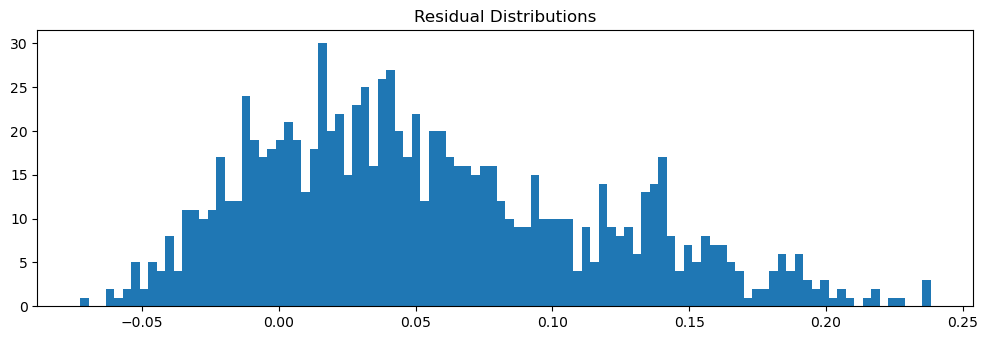

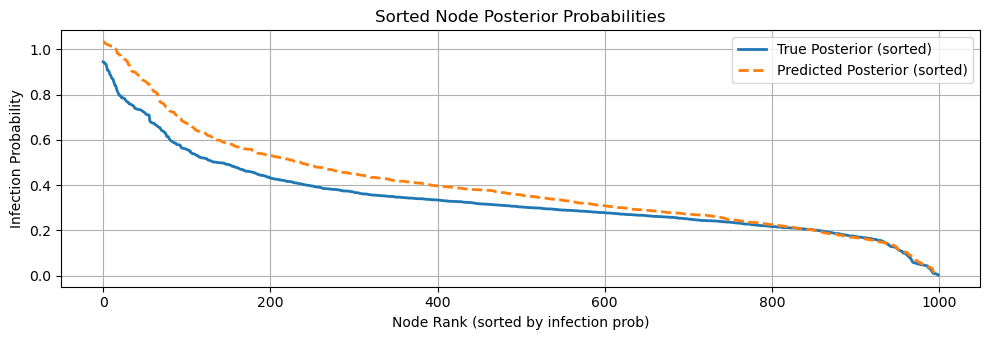

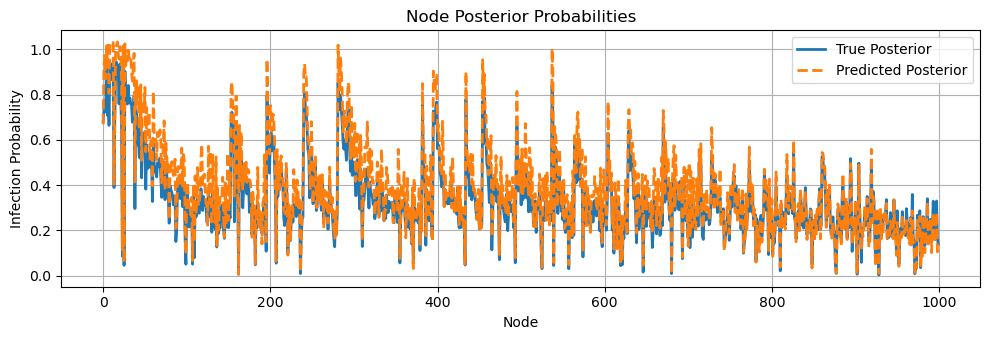

ROC threshold for 50-percentil is 0.30399999022483826


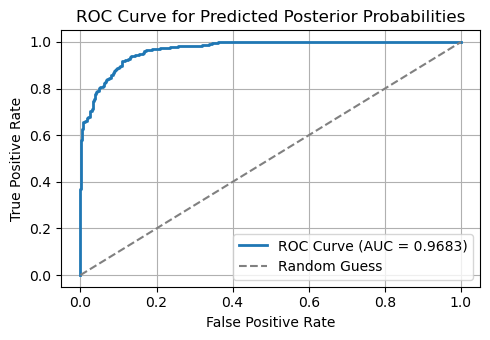

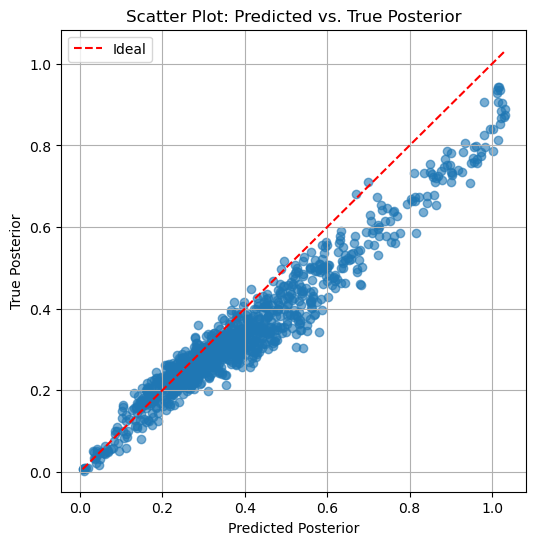

The Pearson correlation:  tensor(0.9712)
The Spearman correlation:  0.954234313782488


In [75]:
start = time.time()
preds_ale_m = modified_ALE(G_test, prior_probs_test,edge_dict_t,4).unsqueeze(1)
end = time.time()
print(f"Runtime: {end - start:.6f} seconds")
rmse_loss_ale_m = torch.nn.MSELoss()(preds_ale_m, true_posterior_tensor)
print(f"ALE Test RMSE Loss: {rmse_loss_ale_m.item()**0.5:.4f}")
posterior_plots(size_x,
                size_y,
                preds_ale_m-prior_probs_test.unsqueeze(1),
                true_posterior_tensor-prior_probs_test.unsqueeze(1))

Runtime: 0.020598 seconds
ALE Test RMSE Loss: 0.0393


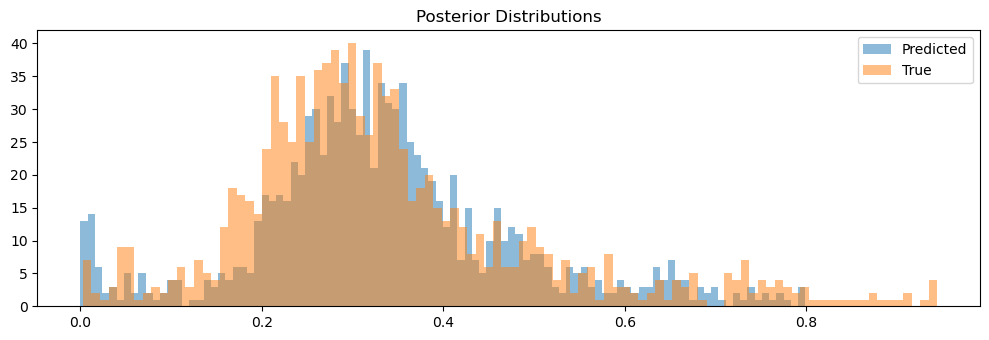

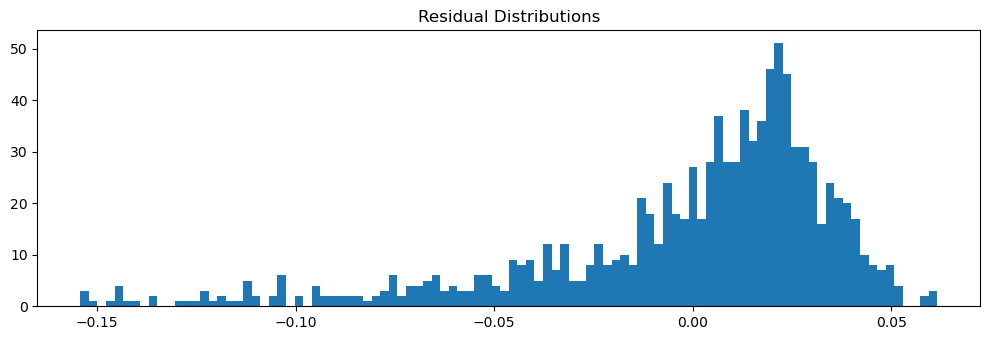

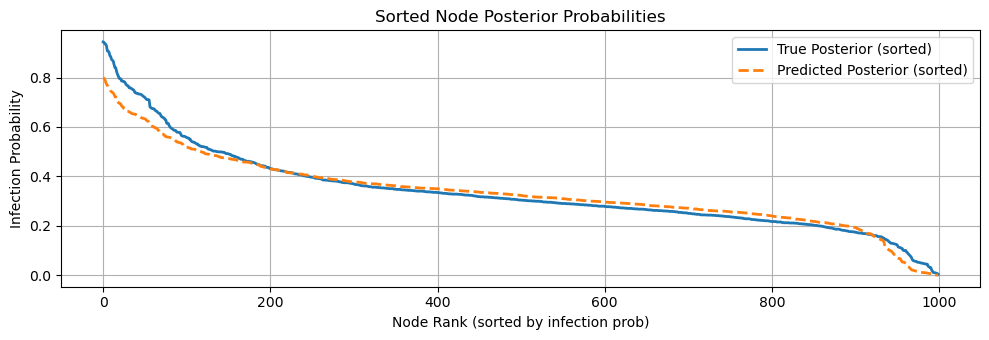

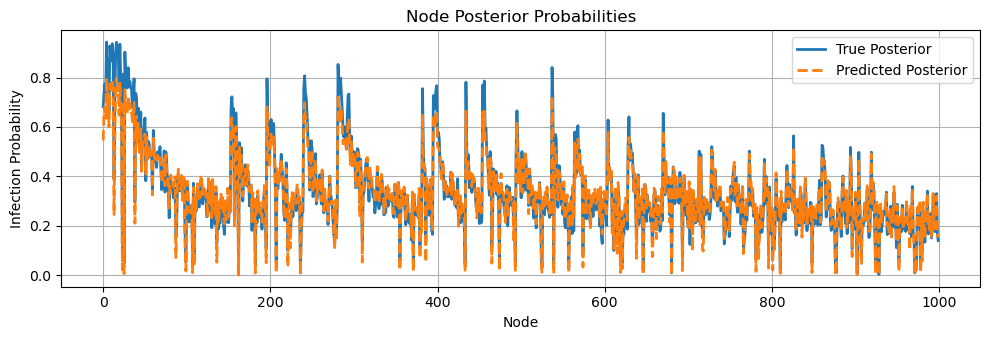

ROC threshold for 50-percentil is 0.30399999022483826


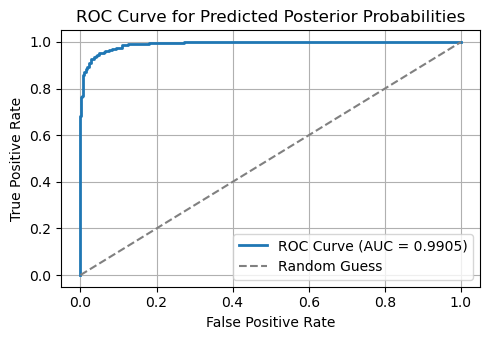

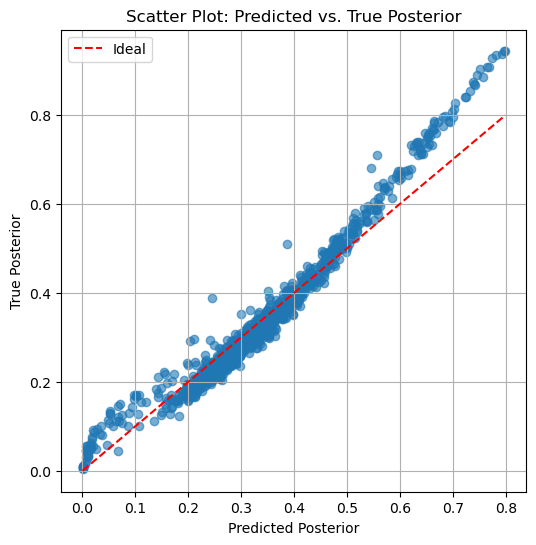

The Pearson correlation:  tensor(0.9776)
The Spearman correlation:  0.9841999559217556


In [76]:
start = time.time()
preds = IC_approx_vectorized(G_test, edge_dict_t, prior_probs_test,15,1)
preds_IC_approx = torch.tensor(preds, dtype=torch.float32).unsqueeze(1)
end = time.time()
print(f"Runtime: {end - start:.6f} seconds")
rmse_loss_IC_approx = torch.nn.MSELoss()(preds_IC_approx, true_posterior_tensor)
print(f"ALE Test RMSE Loss: {rmse_loss_IC_approx.item()**0.5:.4f}")
posterior_plots(size_x,
                size_y,
                preds_IC_approx-prior_probs_test.unsqueeze(1),
                true_posterior_tensor-prior_probs_test.unsqueeze(1))

In [9]:
torch.nn.MSELoss()(preds_IC_approx, true_posterior_tensor).item()**0.5

0.07621115808635875

In [11]:
rmse

array([0.12205464])

Runtime: 0.507278 seconds
ALE Test RMSE Loss: 0.2461


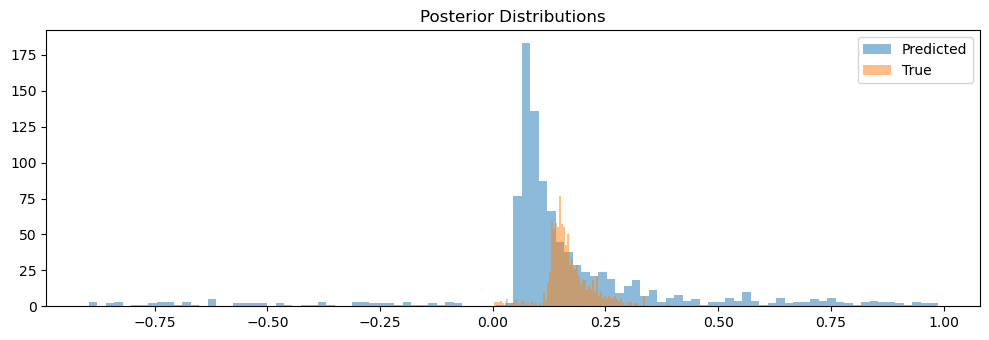

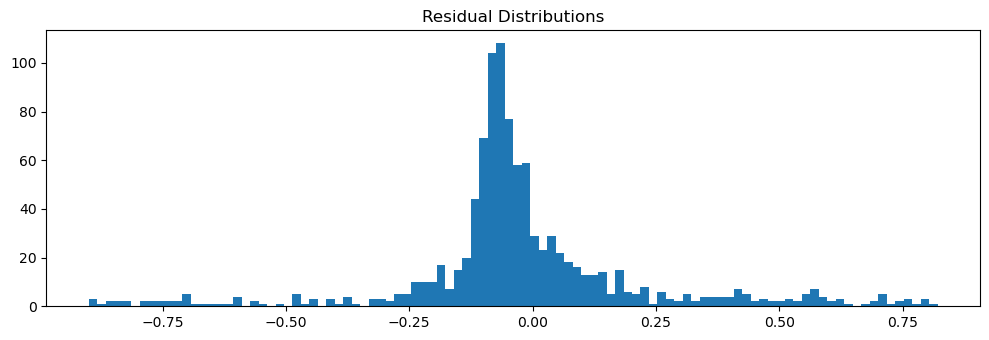

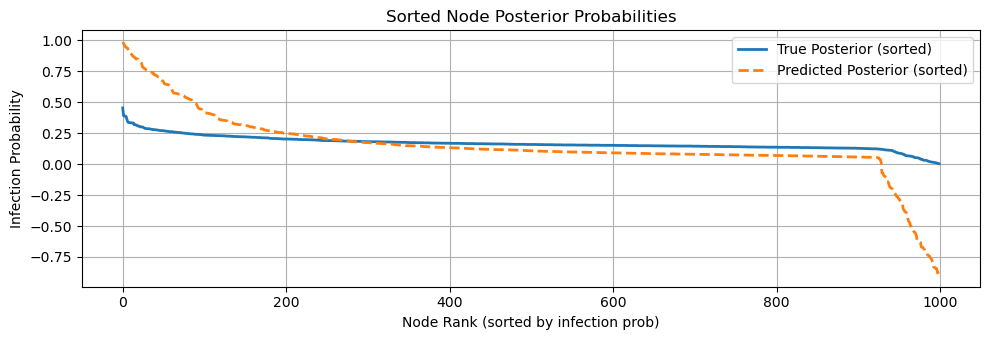

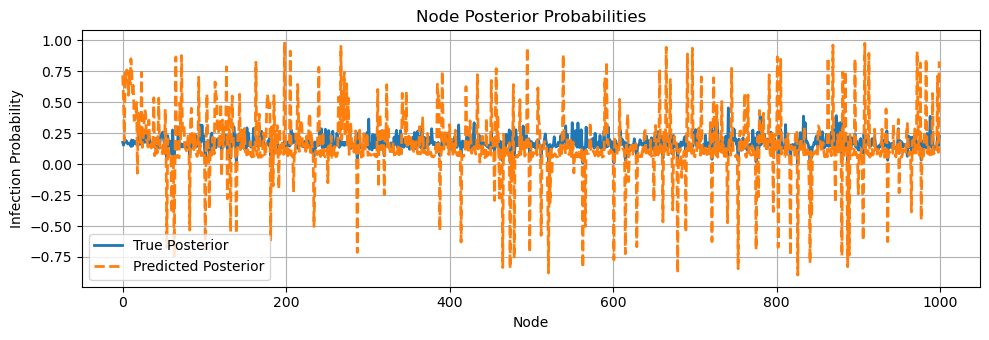

ROC threshold for 50-percentil is 0.1589999943971634


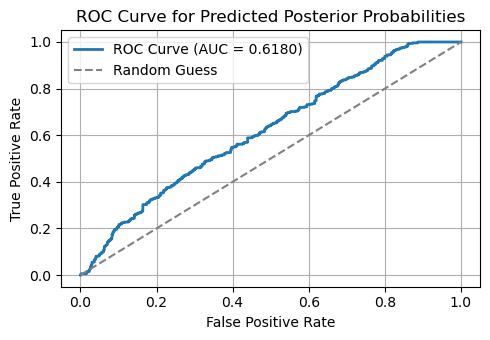

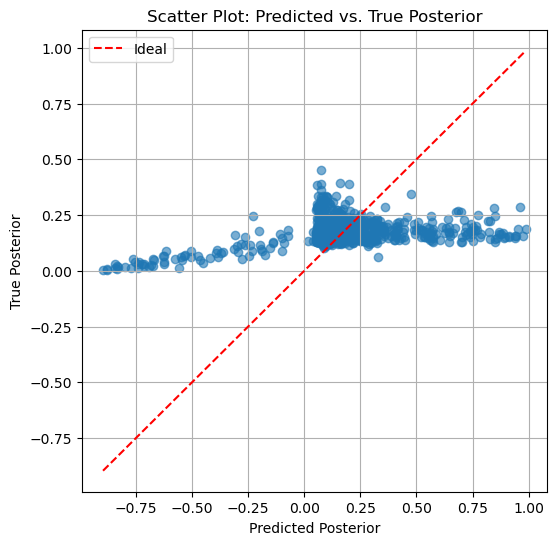

The Pearson correlation:  tensor(0.3964)
The Spearman correlation:  0.25827618080352666


In [49]:
#dmp=dmp_ic(G_test, np.array(prior_probs_test), edge_dict_t,10)
start = time.time()
preds_IC_approx = torch.tensor(
    dmp_ic(G_test, np.array(prior_probs_test), edge_dict_t,20),
    dtype=torch.float32).unsqueeze(1)
end = time.time()
print(f"Runtime: {end - start:.6f} seconds")
rmse_loss_IC_approx = torch.nn.MSELoss()(preds_IC_approx, true_posterior_tensor)
print(f"ALE Test RMSE Loss: {rmse_loss_IC_approx.item()**0.5:.4f}")
posterior_plots(size_x,
                size_y,
                preds_IC_approx-prior_probs_test.unsqueeze(1),
                true_posterior_tensor-prior_probs_test.unsqueeze(1))

In [27]:
preds_IC_approx

tensor([[1.0000],
        [0.7882],
        [1.0000],
        [0.9993],
        [0.9999],
        [0.9998],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9999],
        [0.9995],
        [0.9911],
        [0.9945],
        [1.0000],
        [0.9656],
        [0.9974],
        [0.9299],
        [0.9015],
        [0.9976],
        [0.8209],
        [0.9667],
        [0.9362],
        [0.8876],
        [0.9407],
        [0.9890],
        [0.9145],
        [0.7711],
        [0.8924],
        [0.8901],
        [0.8926],
        [0.9073],
        [0.9854],
        [0.7253],
        [0.9734],
        [0.9143],
        [0.6947],
        [0.9249],
        [0.8925],
        [0.8783],
        [0.8465],
        [0.7171],
        [0.8772],
        [0.5973],
        [0.8969],
        [0.6624],
        [0.7111],
        [0.7772],
        [0.7917],
        [0.7393],
        [0.7591],
        [0.5382],
        [0.6078],
        [0.5584],
        [0.5956],
        [0.8334],
        [0

In [25]:

preds_IC_approx = torch.tensor(
    dynamic_message_passing(G_test, edge_dict_t,np.array(prior_probs_test),10),
    dtype=torch.float32).unsqueeze(1)
rmse_loss_IC_approx = torch.nn.MSELoss()(preds_IC_approx, true_posterior_tensor)
print(f"ALE Test RMSE Loss: {rmse_loss_IC_approx.item()**0.5:.4f}")
posterior_plots(size_x,
                size_y,
                preds_IC_approx-prior_probs_test.unsqueeze(1),
                true_posterior_tensor-prior_probs_test.unsqueeze(1))

ValueError: operands could not be broadcast together with shapes (1000,) (2,) 

Runtime: 0.472881 seconds
ALE Test RMSE Loss: 0.0953


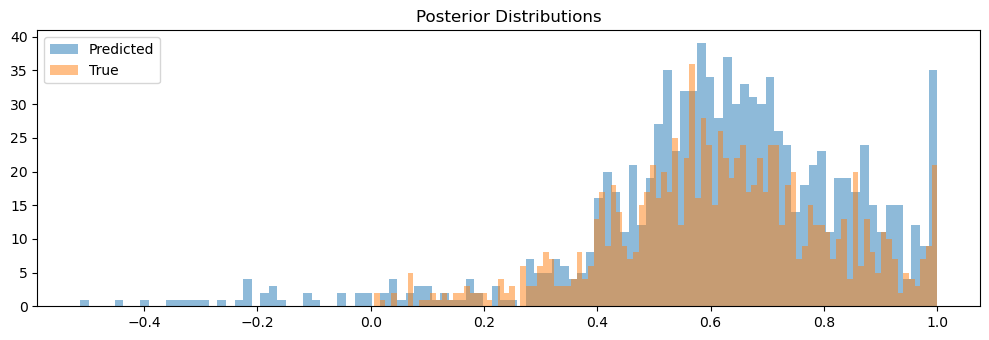

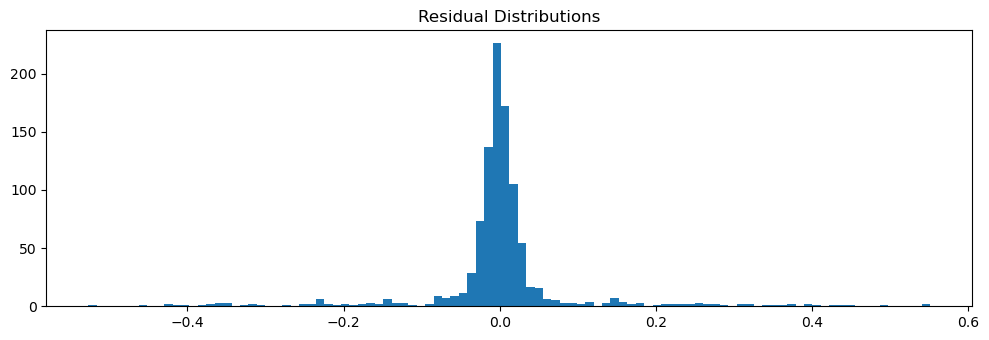

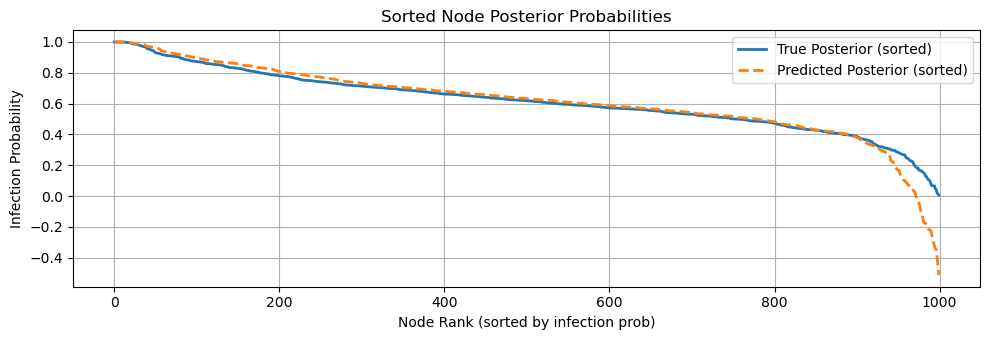

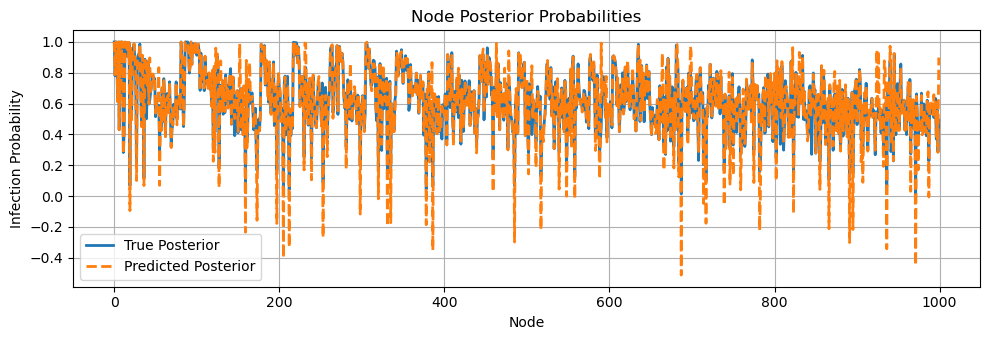

ROC threshold for 50-percentil is 0.6195000112056732


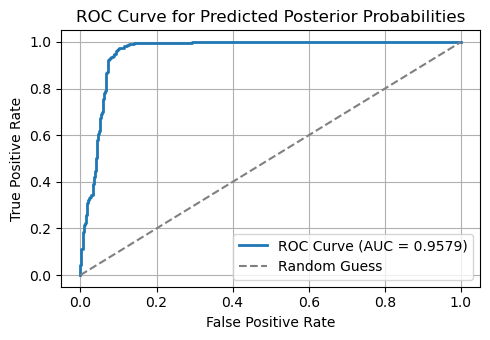

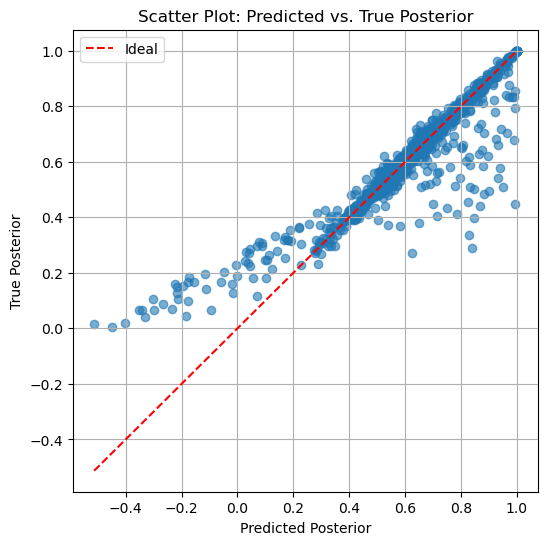

The Pearson correlation:  tensor(0.9230, dtype=torch.float64)
The Spearman correlation:  0.9227539577597389


In [39]:

start = time.time()
preds_IC_approx = torch.tensor(dmp_ic(G_test, prior_probs_test, edge_dict_t, T=10)).unsqueeze(1)
end = time.time()
print(f"Runtime: {end - start:.6f} seconds")
rmse_loss_IC_approx = torch.nn.MSELoss()(preds_IC_approx, true_posterior_tensor)
print(f"ALE Test RMSE Loss: {rmse_loss_IC_approx.item()**0.5:.4f}")
posterior_plots(size_x,
                size_y,
                preds_IC_approx-prior_probs_test.unsqueeze(1),
                true_posterior_tensor-prior_probs_test.unsqueeze(1))

In [9]:
for name, param in trained_model.state_dict().items():
    print(f"{name}:\n{param}\n")

edge_weight:
tensor([0.9134])



# Difussion for linear weighted sum edge weights

Epoch 0, Loss: 0.1022
Epoch 10, Loss: 0.1011
Epoch 20, Loss: 0.1002
Epoch 30, Loss: 0.0995
Epoch 40, Loss: 0.0991
Epoch 50, Loss: 0.0987
Epoch 60, Loss: 0.0985
Epoch 70, Loss: 0.0984
Epoch 80, Loss: 0.0982
Epoch 90, Loss: 0.0982
Epoch 100, Loss: 0.0981
Epoch 110, Loss: 0.0981
Epoch 120, Loss: 0.0980
Epoch 130, Loss: 0.0980
Epoch 140, Loss: 0.0980
Epoch 150, Loss: 0.0980
Epoch 160, Loss: 0.0980
Epoch 170, Loss: 0.0980
Epoch 180, Loss: 0.0980
Epoch 190, Loss: 0.0980
Epoch 200, Loss: 0.0980
Epoch 210, Loss: 0.0980
Epoch 220, Loss: 0.0980
Epoch 230, Loss: 0.0980
Epoch 240, Loss: 0.0980
Epoch 249, Loss: 0.0980


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test RMSE Loss: 0.2141
Test RMSE Loss with priors: 0.6709
RMSE Loss of edges: 0.0457


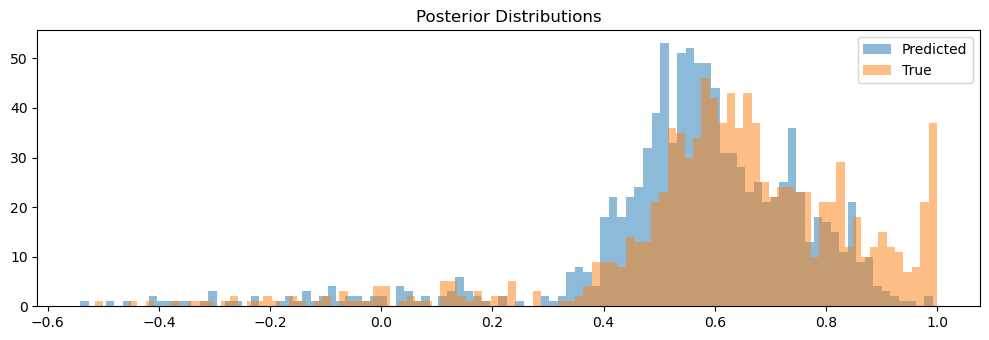

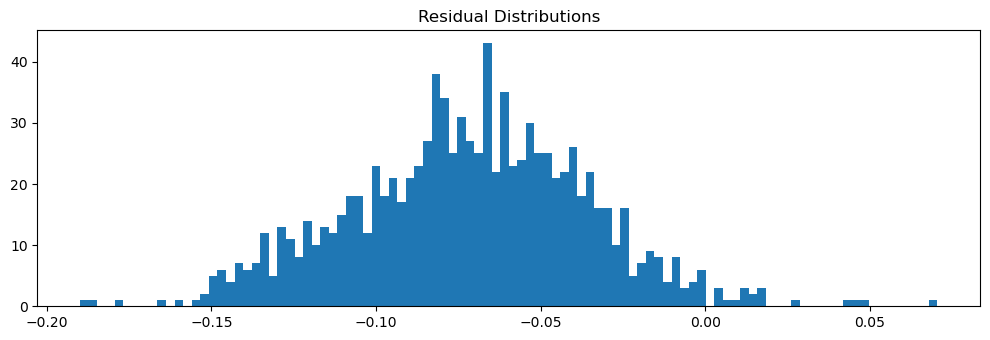

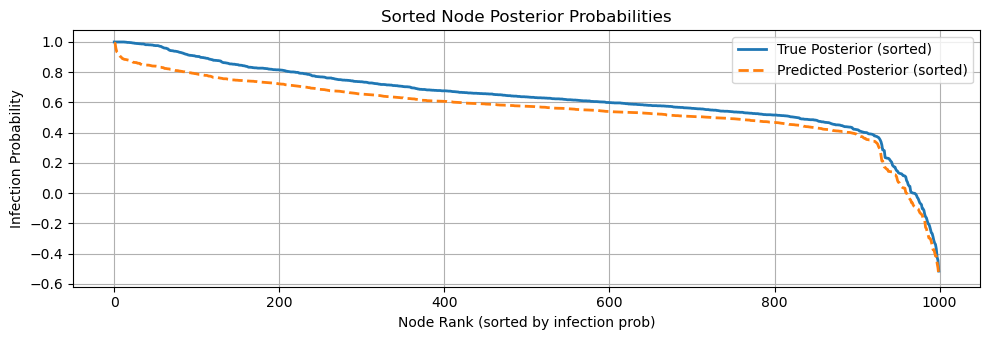

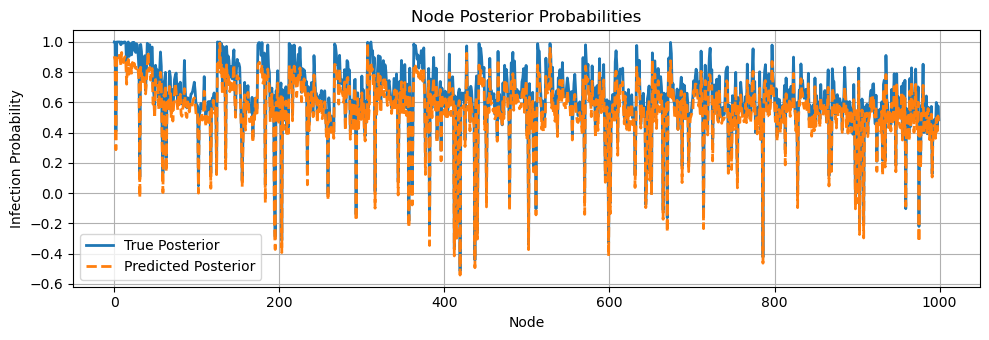

ROC threshold for 95-percentil is 0.9760500103235245


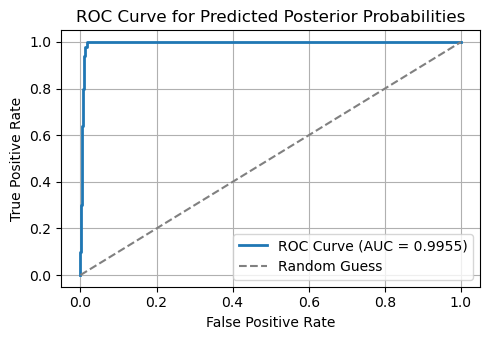

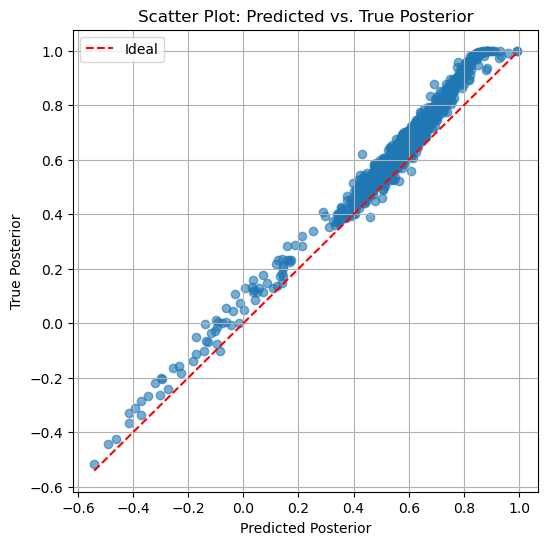

The Pearson correlation:  tensor(0.9895)
The Spearman correlation:  0.9837533832982305


In [77]:
num_nodes=1000
edge_prob=0.1
prob_selected = 0.1
num_edges_per_node=5
num_node_features=5
num_edge_features=5
attribute_distribution="normal"
model_to_use="ICApproxLearnableModule"
# good hyper-parameters for ModifiedALE: lr=0.001, epochs=700
max_edge=0.333
normal = False
if normal:
    node_weights=np.random.normal(size=num_node_features)
    node_weights_source=np.random.normal(size=num_node_features)
    node_weights_sink=np.random.normal(size=num_node_features)
    epsilon=np.random.normal(size=1)*-4
    edge_weights=np.random.normal(size=num_edge_features)
else:
    node_weights=np.random.rand(num_node_features)*2-1
    node_weights_source=np.random.rand(num_node_features)*2-1
    node_weights_sink=np.random.rand(num_node_features)*2-1
    epsilon=np.random.rand(1)*-4
    edge_weights=np.random.rand(num_edge_features)*2-1
b_s=1
b_t=0.5
b_e=1
edge_method='weighted_sum'
alpha=0.1
num_sim=1000
dropout=0.3
'''G, prior_probs,edge_dict = generate_erdos_renyi_attribute_graph(num_nodes,
                                                                edge_prob,
                                                                num_node_features=num_node_features,
                                                                num_edge_features=num_edge_features,
                                                                node_weights=node_weights,
                                                                edge_weights=edge_weights,
                                                                edge_method='weighted_sum')'''
G, prior_probs,edge_dict = generate_barabasi_albert_attribute_graph(num_nodes,
                                                                    num_edges_per_node,
                                                                    num_node_features=num_node_features,
                                                                    num_edge_features=num_edge_features,
                                                                    node_weights=node_weights,
                                                                    edge_weights=edge_weights,
                                                                    edge_method=edge_method,
                                                                    max_edge=max_edge,
                                                                    prob_selected=prob_selected,
                                                                    node_weights_source=node_weights_source,
                                                                    node_weights_sink=node_weights_sink,
                                                                    epsilon=epsilon,
                                                                    b_s=b_s,
                                                                    b_t=b_t,
                                                                    b_e=b_e,
                                                                    attribute_distribution=attribute_distribution)

#edges = list(G.edges())
#edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
#edge_attr = torch.tensor([edge_dict[(u, v)] for (u, v) in edges], dtype=torch.float)

edges = list(edge_dict.keys())  # or better: edges = your edge_index list directly
edge_index = torch.tensor(edges, dtype=torch.long).T  # shape (2, num_edges)
edge_attr = torch.tensor([edge_dict[(u, v)] for (u, v) in edges], dtype=torch.float)

data = Data(x=prior_probs.unsqueeze(1), edge_index=edge_index, edge_attr=edge_attr)

trained_model = train_diffusion_gnn(data,
                                    optimized_independent_cascade, 
                                    num_steps=10,
                                    lr=0.01, 
                                    epochs=250,
                                    hidden_dim=1,
                                    model_to_use=model_to_use,
                                    alpha=alpha,
                                    num_sim=num_sim,
                                    use_difference=False,
                                    alpha1=0, 
                                    alpha2=0,
                                    BCE=False,
                                    dropout=dropout,
                                    reg_const=0.12)

#test data
'''G_test, prior_probs_test,edge_dict_t = generate_erdos_renyi_attribute_graph(num_nodes,
                                                                            edge_prob,
                                                                            num_node_features=num_node_features,
                                                                            num_edge_features=num_edge_features,
                                                                            node_weights=node_weights,
                                                                            edge_weights=edge_weights,
                                                                            edge_method='weighted_sum')'''
G_test, prior_probs_test,edge_dict_t = generate_barabasi_albert_attribute_graph(num_nodes,
                                                                        num_edges_per_node,
                                                                        num_node_features=num_node_features,
                                                                        num_edge_features=num_edge_features,
                                                                        node_weights=node_weights,
                                                                        edge_weights=edge_weights,
                                                                        edge_method=edge_method,
                                                                        max_edge=max_edge,
                                                                        prob_selected=prob_selected,
                                                                        node_weights_source=node_weights_source,
                                                                        node_weights_sink=node_weights_sink,
                                                                        epsilon=epsilon,
                                                                        b_s=b_s,
                                                                        b_t=b_t,
                                                                        b_e=b_e,
                                                                        attribute_distribution=attribute_distribution)

#edges_t = list(G_test.edges())
#edge_index_t = torch.tensor(edges_t, dtype=torch.long).t().contiguous()
#edge_attr_t = torch.tensor([edge_dict_t[(u, v)] for (u, v) in edges_t], dtype=torch.float)

edges_t = list(edge_dict_t.keys())  # or better: edges = your edge_index list directly
edge_index_t = torch.tensor(edges_t, dtype=torch.long).T  # shape (2, num_edges)
edge_attr_t = torch.tensor([edge_dict_t[(u, v)] for (u, v) in edges_t], dtype=torch.float)

data_t = Data(x=prior_probs_test.unsqueeze(1), edge_index=edge_index_t, edge_attr=edge_attr_t)

trained_model.eval()
with torch.no_grad():
    #predicted_posterior = trained_model(data_t.x, data_t.edge_index, data_t.edge_attr)
    predicted_posterior, predicted_edge_probs = trained_model(G, data.x)

# Compare predicted_posterior with true_posterior
#ic = optimized_independent_cascade(G_test, prior_probs_test, edge_dict_t, num_sim)
ic = optimized_independent_cascade(G, prior_probs, edge_dict, num_sim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

true_posterior_tensor = torch.tensor(
    [ic[node] for node in ic],
    dtype=torch.float,
    device=device
).view(-1, 1)
rmse_loss = torch.nn.MSELoss()(predicted_posterior, true_posterior_tensor)
print(f"Test RMSE Loss: {rmse_loss.item()**0.5:.4f}")
rmse_loss_prior = torch.nn.MSELoss()(prior_probs_test.unsqueeze(1), true_posterior_tensor)
print(f"Test RMSE Loss with priors: {rmse_loss_prior.item()**0.5:.4f}")

torch.save(trained_model.state_dict(), 'diffusion_gnn.pth')

rmse_loss = torch.nn.MSELoss()(predicted_edge_probs, edge_attr)
print(f"RMSE Loss of edges: {rmse_loss.item()**0.5:.4f}")

posterior_plots(size_x,
                size_y,
                predicted_posterior.unsqueeze(1)-prior_probs_test.unsqueeze(1),
                true_posterior_tensor-prior_probs_test.unsqueeze(1),
                percentile=95)

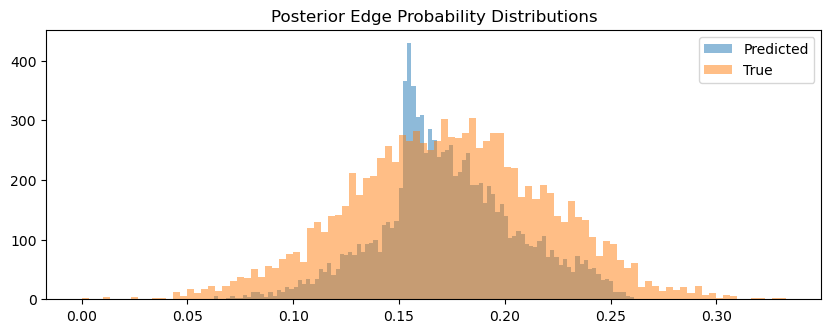

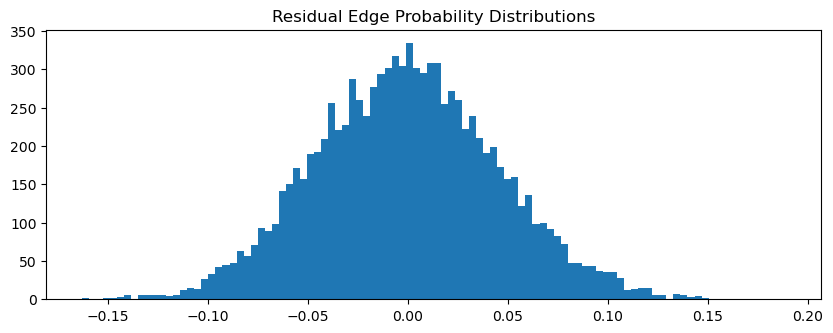

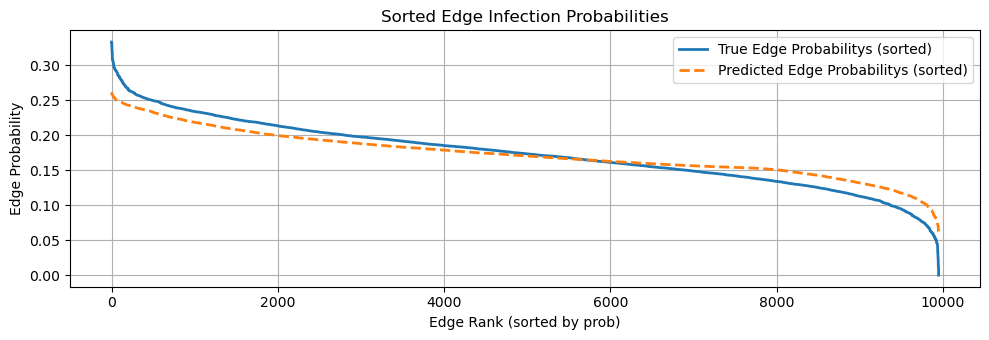

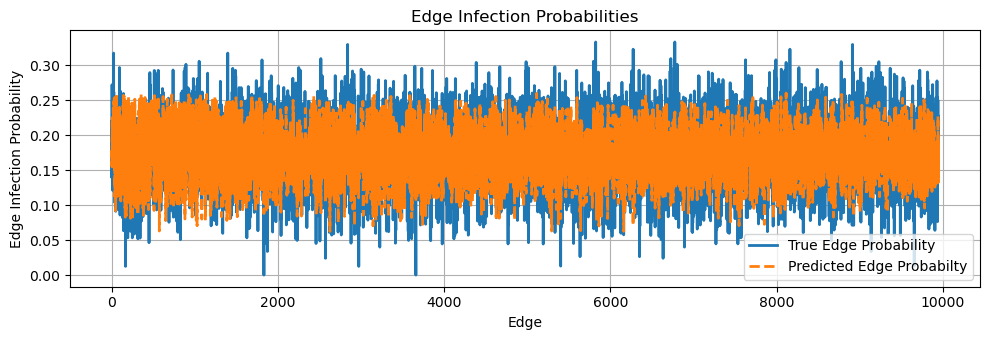

The Pearson correlation:  tensor(0.3733)
The Spearman correlation:  0.34540206402905776


In [78]:
#print(torch.corrcoef(torch.stack([predicted_edge_probs, edge_attr])))
edge_plots(size_x, size_y, predicted_edge_probs.detach(), edge_attr)

Runtime: 0.008894 seconds
ALE Test RMSE Loss: 0.1214


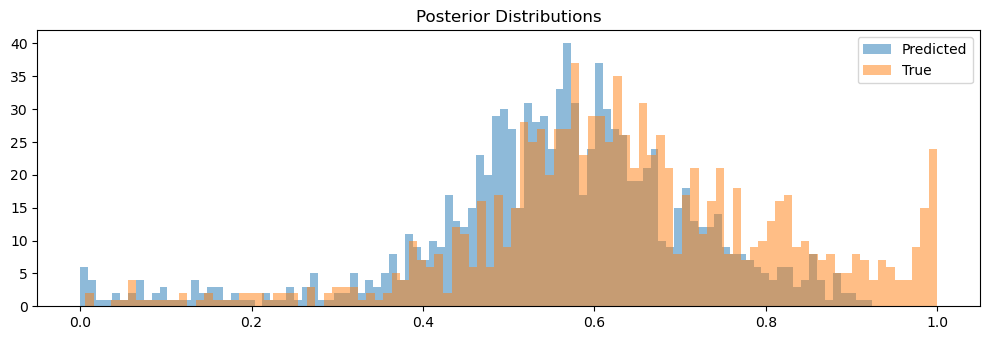

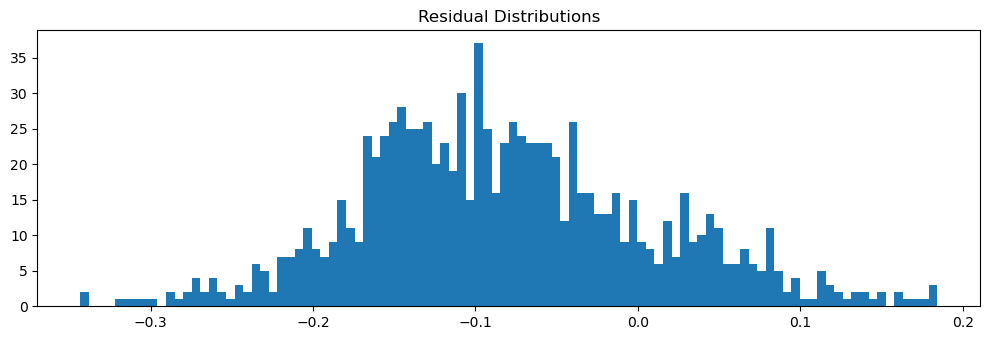

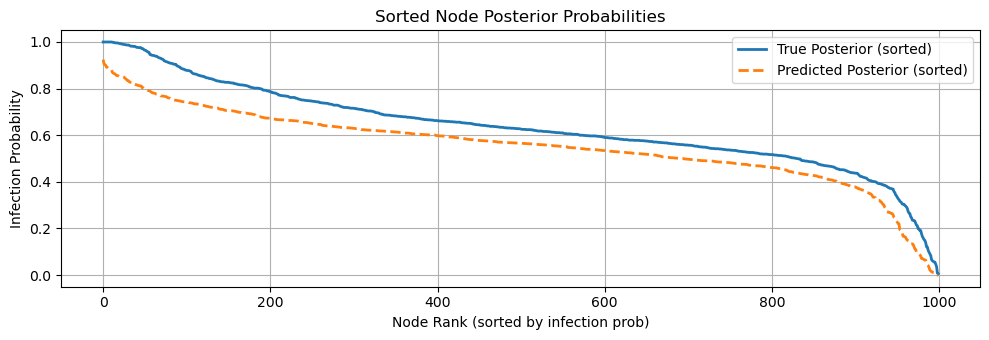

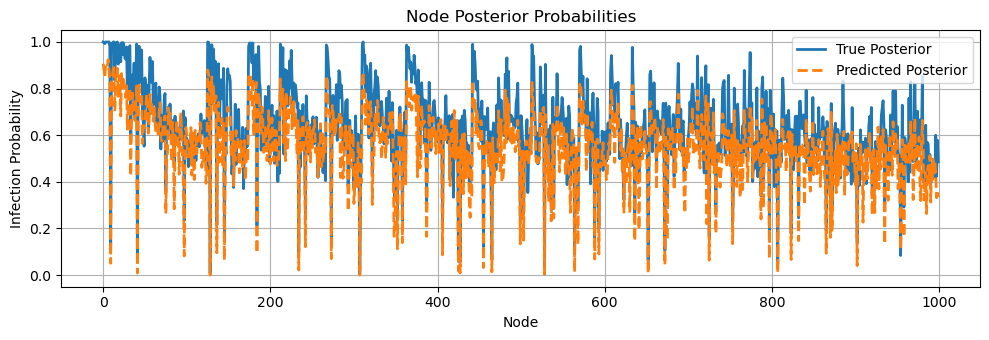

ROC threshold for 50-percentil is 0.6264999806880951


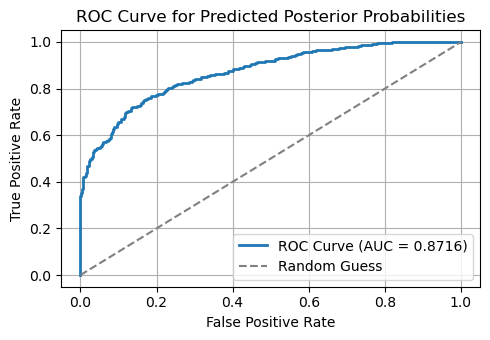

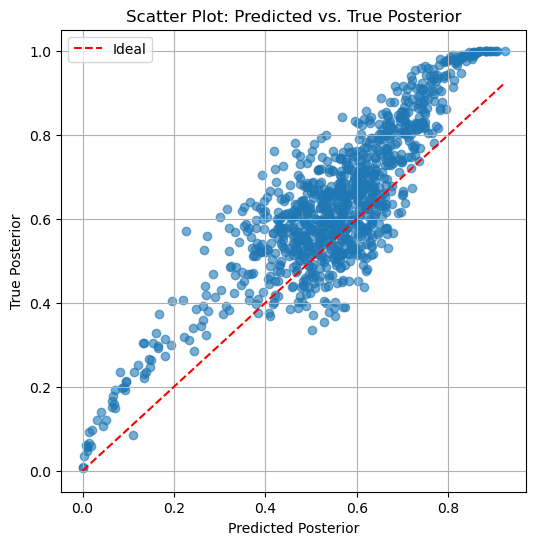

The Pearson correlation:  tensor(0.8687)
The Spearman correlation:  0.7821036191797933


In [80]:
#predicted_edge_dict = edge_index_to_dict(edge_index, predicted_edge_probs.detach())
mean_edge_prob = edge_attr.mean()
mean_edge_dict = {}
for (u,v) in G.edges():
    mean_edge_dict[(u,v)] = np.random.uniform(0, 1/3)

start = time.time()
preds = IC_approx_vectorized(G, mean_edge_dict, prior_probs,10,1)
preds_IC_approx = torch.tensor(preds, dtype=torch.float32).unsqueeze(1)
end = time.time()
print(f"Runtime: {end - start:.6f} seconds")
rmse_loss_IC_approx = torch.nn.MSELoss()(preds_IC_approx, true_posterior_tensor)
print(f"ALE Test RMSE Loss: {rmse_loss_IC_approx.item()**0.5:.4f}")
posterior_plots(size_x,
                size_y,
                preds_IC_approx-prior_probs.unsqueeze(1),
                true_posterior_tensor-prior_probs.unsqueeze(1))

In [62]:

start = time.time()
ic = optimized_independent_cascade(G, prior_probs, edge_dict, num_sim)
end = time.time()
print(f"Runtime: {end - start:.6f} seconds")

Runtime: 5.656871 seconds


In [5]:
740, 9860,9835

tensor([0.1361, 0.1703, 0.1807,  ..., 0.1710, 0.1824, 0.1878])

## ALE heuristic

/home/matic/Documents/IMreasearch/py_scripts/diffusion_models/independent_cascade.py:311: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(prior_probs, dtype=torch.float32).view(-1, 1)  # (N, 1)


ALE Test RMSE Loss: 0.5400


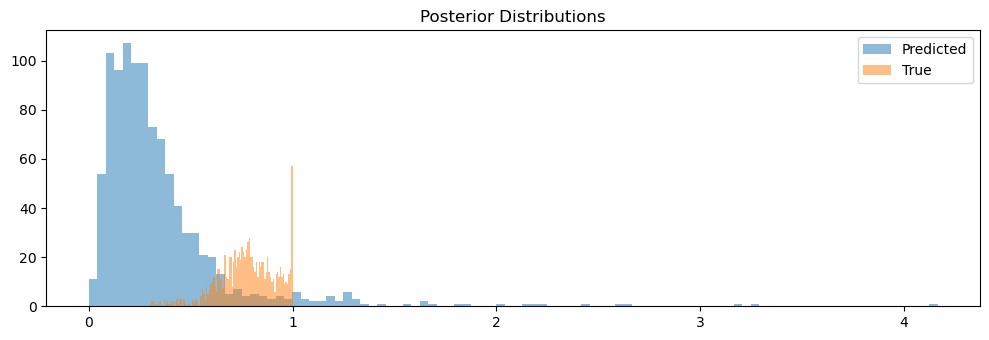

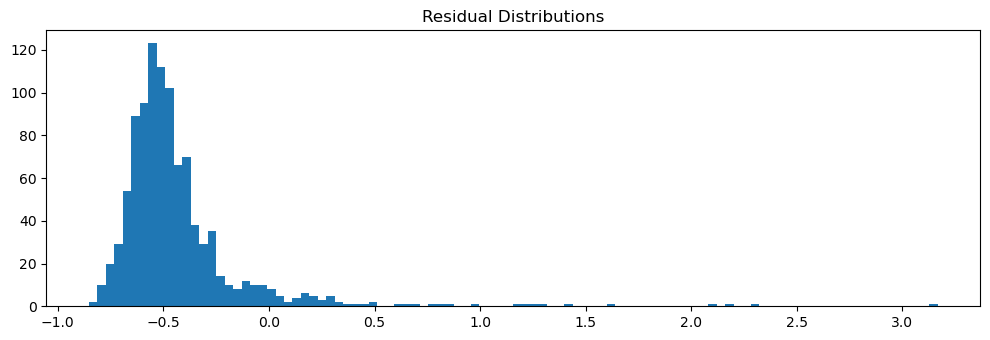

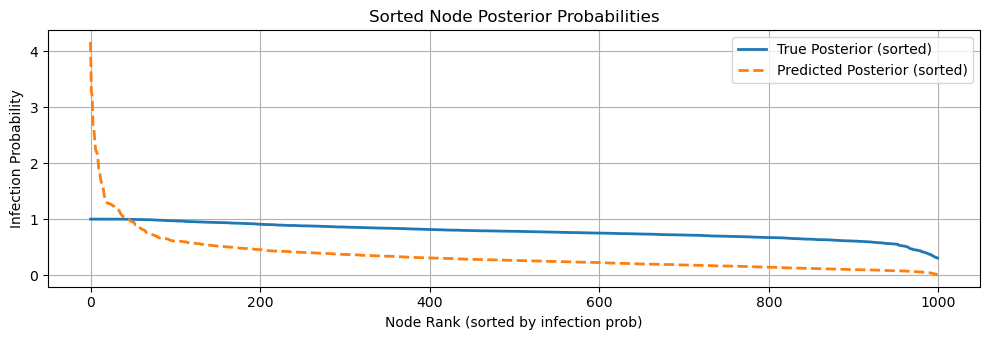

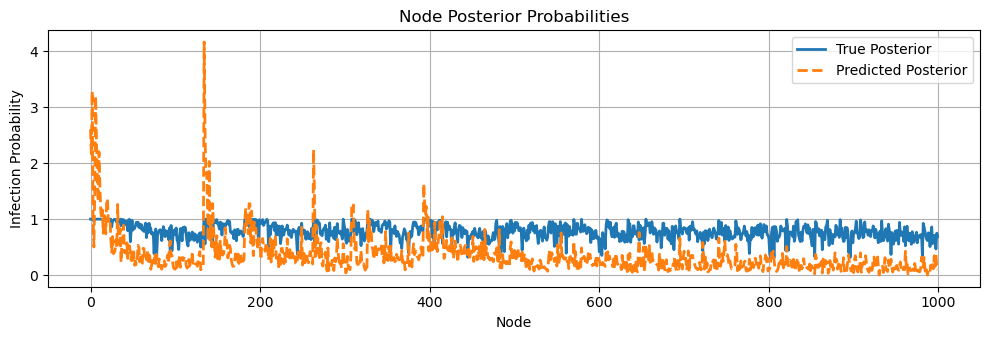

ROC threshold for 50-percentil is 0.7820000052452087


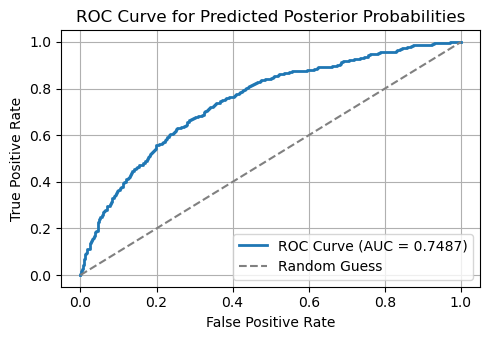

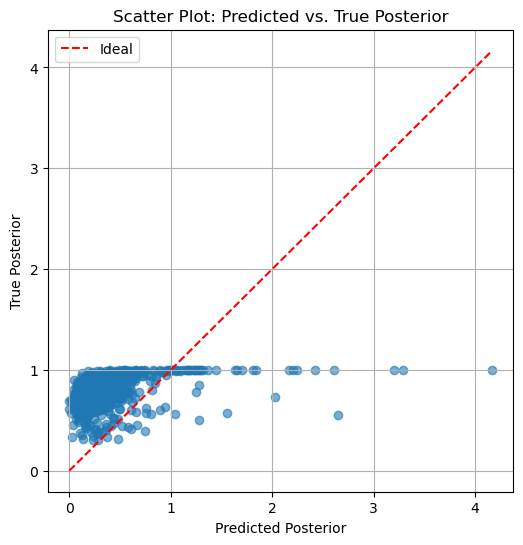

The Pearson correlation:  tensor(0.3941)
The Spearman correlation:  0.5232652072165698


In [18]:
preds_ale = ALE_heuristic(G_test, prior_probs_test,edge_dict_t,3).unsqueeze(1)
rmse_loss_ale = torch.nn.MSELoss()(preds_ale, true_posterior_tensor)
print(f"ALE Test RMSE Loss: {rmse_loss_ale.item()**0.5:.4f}")
posterior_plots(size_x,
                size_y,
                preds_ale-prior_probs_test.unsqueeze(1),
                true_posterior_tensor-prior_probs_test.unsqueeze(1))

/home/matic/Documents/IMreasearch/py_scripts/diffusion_models/independent_cascade.py:495: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(prior_probs, dtype=torch.float32).view(-1, 1)


ALE Test RMSE Loss: 0.7395


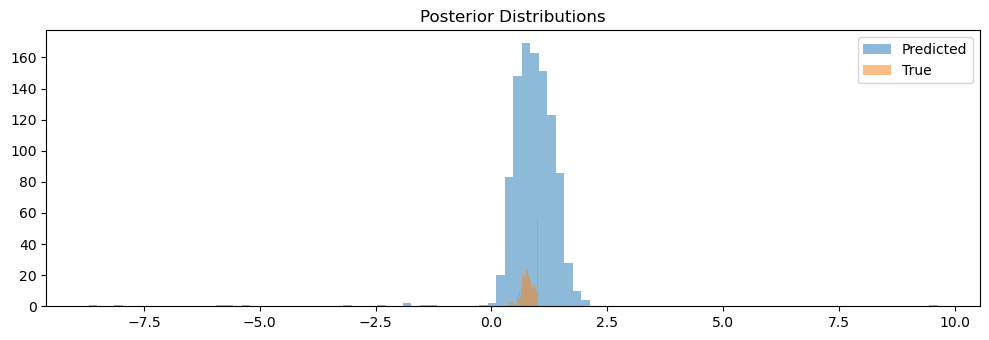

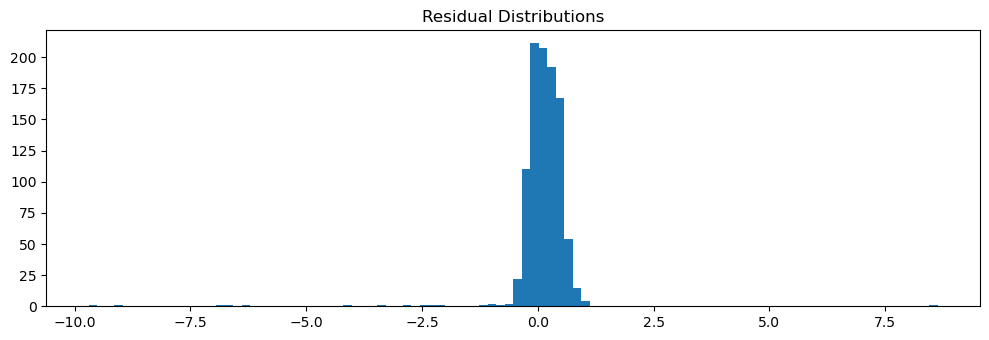

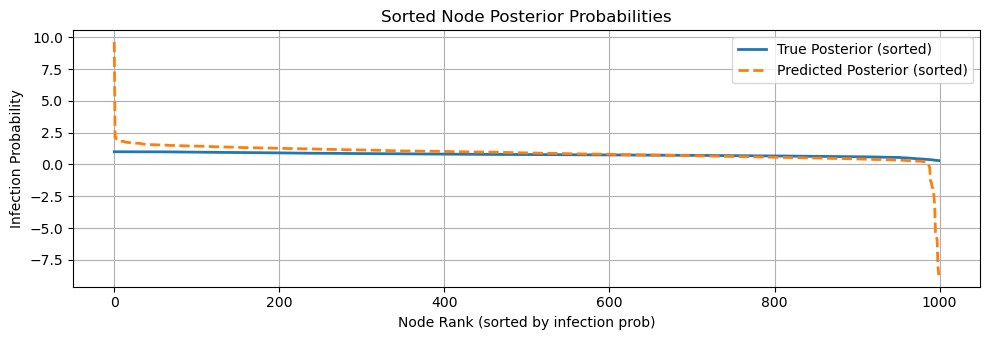

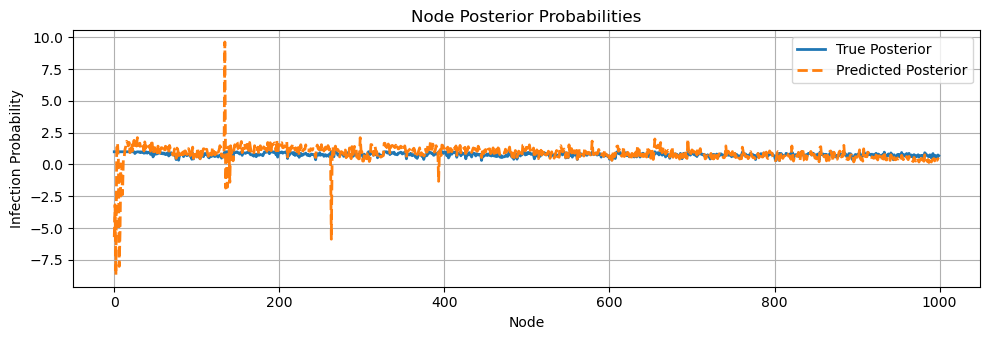

ROC threshold for 50-percentil is 0.7820000052452087


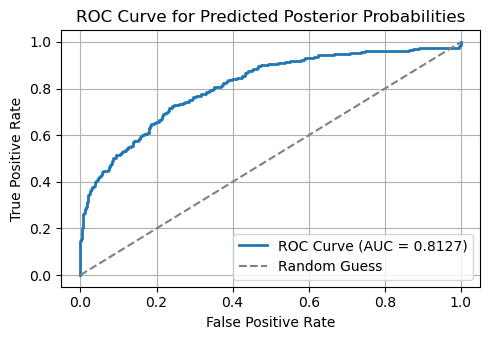

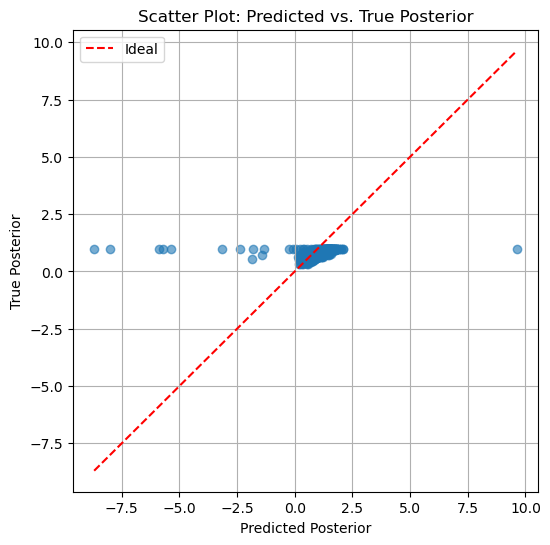

The Pearson correlation:  tensor(0.2467)
The Spearman correlation:  0.641605774841632


In [19]:
preds_ale_m = modified_ALE(G_test, prior_probs_test,edge_dict_t,3).unsqueeze(1)
rmse_loss_ale_m = torch.nn.MSELoss()(preds_ale_m, true_posterior_tensor)
print(f"ALE Test RMSE Loss: {rmse_loss_ale_m.item()**0.5:.4f}")
posterior_plots(size_x,
                size_y,
                preds_ale_m-prior_probs_test.unsqueeze(1),
                true_posterior_tensor-prior_probs_test.unsqueeze(1))

ALE Test RMSE Loss: 0.1972


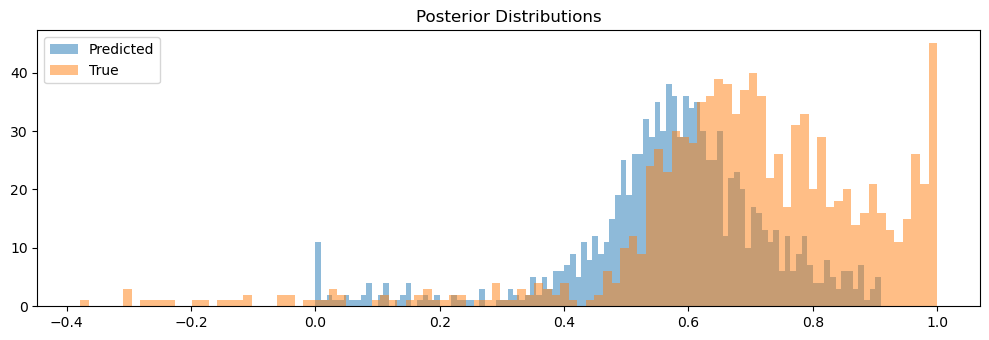

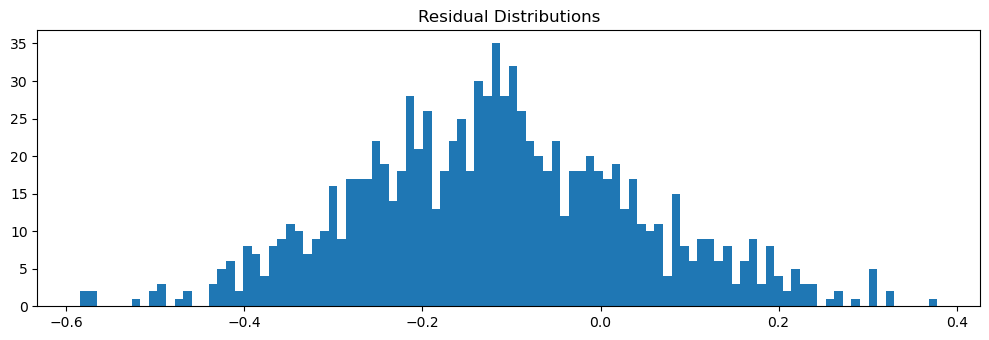

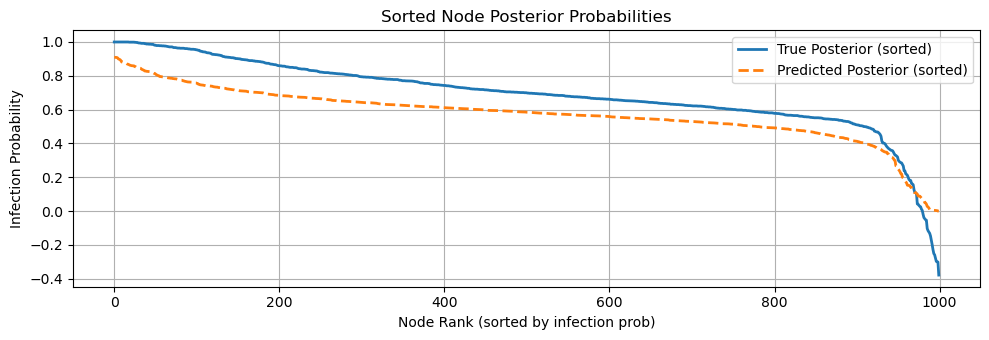

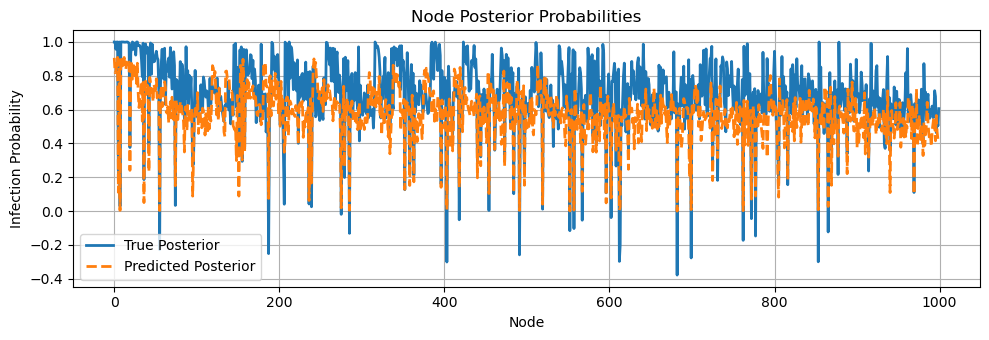

ROC threshold for 50-percentil is 0.6994999945163727


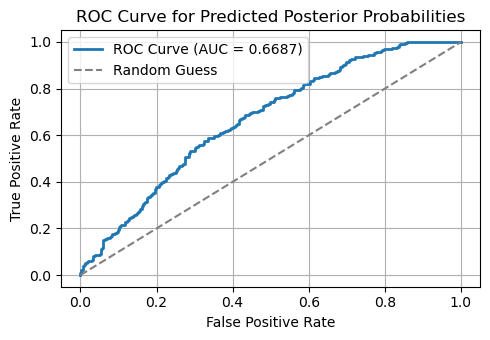

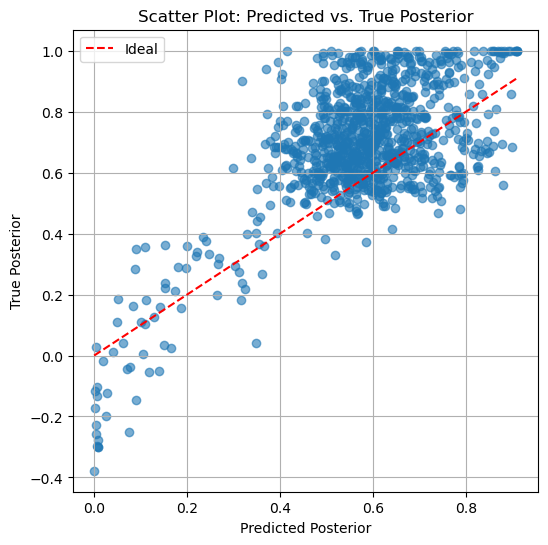

The Pearson correlation:  tensor(0.6740)
The Spearman correlation:  0.3980349555914347


In [4]:
preds_IC_approx = torch.tensor(IC_approx_vectorized(G_test, edge_dict_t, prior_probs_test,15), dtype=torch.float32).unsqueeze(1)
rmse_loss_IC_approx = torch.nn.MSELoss()(preds_IC_approx, true_posterior_tensor)
print(f"ALE Test RMSE Loss: {rmse_loss_IC_approx.item()**0.5:.4f}")
posterior_plots(size_x,
                size_y,
                preds_IC_approx-prior_probs_test.unsqueeze(1),
                true_posterior_tensor-prior_probs_test.unsqueeze(1))

In [18]:
for name, param in trained_model.state_dict().items():
    print(f"{name}:\n{param}\n")

edge_weight:
tensor([0.6869, 0.6066, 0.6653, 0.8781, 1.2281])



# The inverse infection problem for linear weighted sum

In [81]:


num_nodes=1000
edge_prob=0.1
prob_selected = 0.1
num_edges_per_node=3
num_node_features=5
num_edge_features=5
attribute_distribution="normal"
#edge_method='weighted_sum'
# good hyper-parameters for ModifiedALE: lr=0.001, epochs=700
max_edge=1/3
normal = False
if normal:
    node_weights=np.random.normal(size=num_node_features)
    node_weights_source=np.random.normal(size=num_node_features)
    node_weights_sink=np.random.normal(size=num_node_features)
    epsilon=np.random.normal(size=1)*-4
    edge_weights=np.random.normal(size=num_edge_features)
else:
    node_weights=np.random.rand(num_node_features)*2-1
    node_weights_source=np.random.rand(num_node_features)*2-1
    node_weights_sink=np.random.rand(num_node_features)*2-1
    epsilon=np.random.rand(1)*-4
    edge_weights=np.random.rand(num_edge_features)*2-1
# ---- 1. Setup ----
num_nodes=1000
alpha = 0.9
b_s=1
b_t=0.5
b_e=1
edge_method='weighted_sum'
num_sim=1000
dropout=0.3
#edge_prob=0.1
#num_edges_per_node=3
#num_node_features=5
#num_edge_features=5
#max_edge=1
#node_weights=np.random.rand(num_node_features)
#edge_weights=np.random.rand(num_edge_features)
'''G, prior_probs, edge_dict = generate_erdos_renyi_attribute_graph(num_nodes,
                                                                edge_prob,
                                                                num_node_features=num_node_features,
                                                                num_edge_features=num_edge_features,
                                                                node_weights=node_weights,
                                                                edge_weights=edge_weights,
                                                                edge_method='weighted_sum')'''
G, prior_probs,edge_dict = generate_barabasi_albert_attribute_graph(num_nodes,
                                                                    num_edges_per_node,
                                                                    num_node_features=num_node_features,
                                                                    num_edge_features=num_edge_features,
                                                                    node_weights=node_weights,
                                                                    edge_weights=edge_weights,
                                                                    edge_method=edge_method,
                                                                    max_edge=max_edge,
                                                                    prob_selected=prob_selected,
                                                                    node_weights_source=node_weights_source,
                                                                    node_weights_sink=node_weights_sink,
                                                                    epsilon=epsilon,
                                                                    b_s=b_s,
                                                                    b_t=b_t,
                                                                    b_e=b_e,
                                                                    attribute_distribution=attribute_distribution,
                                                                    max_node_features=0.5)

'''G_t, prior_probs_t, edge_dict_t = generate_erdos_renyi_attribute_graph(num_nodes,
                                                                edge_prob,
                                                                num_node_features=num_node_features,
                                                                num_edge_features=num_edge_features,
                                                                node_weights=node_weights,
                                                                edge_weights=edge_weights,
                                                                edge_method='weighted_sum')'''
G_t, prior_probs_t, edge_dict_t = generate_barabasi_albert_attribute_graph(num_nodes,
                                                                        num_edges_per_node,
                                                                        num_node_features=num_node_features,
                                                                        num_edge_features=num_edge_features,
                                                                        node_weights=node_weights,
                                                                        edge_weights=edge_weights,
                                                                        edge_method=edge_method,
                                                                        max_edge=max_edge,
                                                                        prob_selected=prob_selected,
                                                                        node_weights_source=node_weights_source,
                                                                        node_weights_sink=node_weights_sink,
                                                                        epsilon=epsilon,
                                                                        b_s=b_s,
                                                                        b_t=b_t,
                                                                        b_e=b_e,
                                                                        attribute_distribution=attribute_distribution,
                                                                        max_node_features=0.5)

# Generate edge index and edge features
edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
edge_index_t = torch.tensor(list(G_t.edges), dtype=torch.long).t().contiguous()

edge_attr = torch.tensor(np.array([G.edges[e]['features'] for e in G.edges()]), dtype=torch.float)
edge_attr_t = torch.tensor(np.array([G_t.edges[e]['features'] for e in G_t.edges()]), dtype=torch.float)

edges = list(G.edges())
edges_t = list(G_t.edges())

edge_probs = torch.tensor([edge_dict[(u, v)] for (u, v) in edge_dict], dtype=torch.float)
edge_probs_t = torch.tensor([edge_dict_t[(u, v)] for (u, v) in edge_dict_t], dtype=torch.float)

node_features = torch.tensor(
    [G.nodes[node]['features'] for node in G.nodes()],
    dtype=torch.float32
)
node_features_t = torch.tensor(
    [G_t.nodes[node]['features'] for node in G_t.nodes()],
    dtype=torch.float32
)

# Create PyTorch Geometric Data object
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
data_for_diff = {
    "G" : G,
    "prior_probs" : prior_probs,
    "edge_dict" : edge_dict,
    "k" : 10
}
data_t = Data(x=node_features_t, edge_index=edge_index_t, edge_attr=edge_attr_t)
# ---- 2. Generate True Posteriors with IC ----
true_posteriors = optimized_independent_cascade(G, prior_probs, edge_dict, k=1000)
true_posteriors_t = optimized_independent_cascade(G_t, prior_probs_t, edge_dict_t, k=1000)
true_posterior_tensor = torch.tensor(
    [true_posteriors[i] for i in range(num_nodes)], dtype=torch.float32
).unsqueeze(1)
true_posterior_tensor_t = torch.tensor(
    [true_posteriors_t[i] for i in range(num_nodes)], dtype=torch.float32
).unsqueeze(1)

# ---- 3. Load Pretrained DiffusionGNN ----
#diffusion_gnn = LearnableDiffusionGNN(num_steps=5)
#diffusion_gnn = MultiplicativeDiffusionGNN(num_steps=5)
#diffusion_gnn = ALE(num_steps=10)
#diffusion_gnn = ModifiedALE(num_steps=10,num_nodes=0,num_edges=0)
#diffusion_gnn=ICApproxLayer(num_steps=5,num_nodes=num_nodes)
#diffusion_gnn = GCNMultiplicativeDiffusionGNN(num_steps=3)
'''diffusion_gnn.load_state_dict(torch.load('diffusion_gnn.pth', weights_only=True))
diffusion_gnn.eval()
for param in diffusion_gnn.parameters():
    param.requires_grad = False'''

# ---- 4. Initialize EdgeGNN ----
#edge_gnn = EdgeGNN(node_in_channels=data.x.size(1),edge_in_channels=data.edge_attr.size(1), hidden_channels=64)
edge_gnn = simpleEdgePrediction(node_in_channels=data.x.size(1),edge_in_channels=data.edge_attr.size(1))
#edge_gnn = EdgeGAT(node_in_channels=data.x.size(1),edge_in_channels=data.edge_attr.size(1), hidden_channels=32)
#edge_gnn = StructureAwareEdgeGNN(node_in_channels=data.x.size(1),edge_in_channels=data.edge_attr.size(1), hidden_channels=32)

# ---- 5. Train EdgeGNN using DiffusionGNN supervision ----
'''trained_edge_gnn = train_edge_model_with_diffusion(
    edge_gnn=edge_gnn,
    diffusion_gnn=diffusion_gnn,
    data=data,
    true_posterior_tensor=true_posterior_tensor,
    epochs=700,
    lr=0.001,
    alpha=alpha
)'''
trained_edge_gnn = train_edge_model(
    data_for_diff,
    edge_gnn=edge_gnn,
    data=data,
    true_posterior_tensor=true_posterior_tensor,
    epochs=500,
    lr=0.001,
    alpha=alpha
)

# ---- 6. Evaluate ----
diff_model = ICApproxLossModule()
trained_edge_gnn.eval()
with torch.no_grad():
    predicted_edge_probs = trained_edge_gnn(data.x, data.edge_index, data.edge_attr)
    #predicted_posterior = diff_model(G, prior_probs, data.edge_index, edge_probs, 10).unsqueeze(1)
    predicted_edge_dict = edge_index_to_dict(edge_index, predicted_edge_probs)
    predicted_posterior_dict = optimized_independent_cascade(G, prior_probs, predicted_edge_dict, k=1000)
    predicted_posterior = torch.tensor(
        [predicted_posterior_dict[i] for i in range(num_nodes)], dtype=torch.float32
    ).unsqueeze(1)
    #predicted_posterior = diffusion_gnn(prior_probs.unsqueeze(1), data.edge_index, predicted_edge_probs.unsqueeze(1))

    predicted_edge_probs_t = trained_edge_gnn(data_t.x, data_t.edge_index, data_t.edge_attr)
    #predicted_posterior_t = diff_model(G_t, prior_probs_t, data_t.edge_index, edge_probs_t, 10).unsqueeze(1)
    predicted_edge_dict_t = edge_index_to_dict(edge_index_t, predicted_edge_probs_t)
    predicted_posterior_dict_t = optimized_independent_cascade(G_t, prior_probs_t, predicted_edge_dict_t, k=1000)
    predicted_posterior_t = torch.tensor(
        [predicted_posterior_dict_t[i] for i in range(num_nodes)], dtype=torch.float32
    ).unsqueeze(1)
    #predicted_posterior_t = diffusion_gnn(prior_probs_t.unsqueeze(1), data_t.edge_index, predicted_edge_probs_t.unsqueeze(1))
    
    rmse = torch.sqrt(torch.nn.functional.mse_loss(predicted_posterior, true_posterior_tensor))
    print(f"Final RMSE: {rmse.item():.4f}")
    rmse_edge = torch.sqrt(torch.nn.functional.mse_loss(predicted_edge_probs.unsqueeze(1).squeeze(1), torch.tensor([edge_dict[e] for e in edge_dict])))
    print(f"Final rmse of the edge probs: {rmse_edge.item():.4f}")

    rmse_t = torch.sqrt(torch.nn.functional.mse_loss(predicted_posterior_t, true_posterior_tensor_t))
    print(f"Final Test RMSE: {rmse_t.item():.4f}")
    rmse_edge_t = torch.sqrt(torch.nn.functional.mse_loss(predicted_edge_probs_t.unsqueeze(1).squeeze(1), torch.tensor([edge_dict_t[e] for e in edge_dict_t])))
    print(f"Final Test rmse of the edge probs: {rmse_edge_t.item():.4f}")

    rmse_prior = torch.sqrt(torch.nn.functional.mse_loss(prior_probs_t.unsqueeze(1), true_posterior_tensor_t))
    print(f"Final Test RMSE with priors: {rmse_prior.item():.4f}")

m = torch.tensor([edge_dict_t[e] for e in edge_dict_t]).mean()
m_tensor = torch.ones(torch.tensor([edge_dict_t[e] for e in edge_dict_t]).size()[0])*m
rmse_edge_m = torch.sqrt(torch.nn.functional.mse_loss(m_tensor, torch.tensor([edge_dict_t[e] for e in edge_dict_t])))
print(f"Final rmse of the edge probs with the mean: {rmse_edge_m.item():.4f}")

random_edge_probs = torch.rand(m_tensor.size()[0], 1)*max_edge
rmse_edge_rand = torch.sqrt(torch.nn.functional.mse_loss(random_edge_probs, torch.tensor([edge_dict_t[e] for e in edge_dict_t]).squeeze()))
print(f"Final rmse of the edge probs with random edge weights: {rmse_edge_rand.item():.4f}")

# For the purpose of the graphics


/tmp/ipykernel_391392/1732142193.py:103: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  node_features = torch.tensor(


Epoch 0, Loss: 0.2009
Epoch 10, Loss: 0.1967
Epoch 20, Loss: 0.1920
Epoch 30, Loss: 0.1876
Epoch 40, Loss: 0.1826
Epoch 50, Loss: 0.1772
Epoch 60, Loss: 0.1715
Epoch 70, Loss: 0.1653
Epoch 80, Loss: 0.1582
Epoch 90, Loss: 0.1502
Epoch 100, Loss: 0.1425
Epoch 110, Loss: 0.1328
Epoch 120, Loss: 0.1237
Epoch 130, Loss: 0.1137
Epoch 140, Loss: 0.1027
Epoch 150, Loss: 0.0928
Epoch 160, Loss: 0.0813
Epoch 170, Loss: 0.0706
Epoch 180, Loss: 0.0633
Epoch 190, Loss: 0.0566
Epoch 200, Loss: 0.0540
Epoch 210, Loss: 0.0526
Epoch 220, Loss: 0.0518
Epoch 230, Loss: 0.0514
Epoch 240, Loss: 0.0515
Epoch 250, Loss: 0.0511
Epoch 260, Loss: 0.0517
Epoch 270, Loss: 0.0510
Epoch 280, Loss: 0.0507
Epoch 290, Loss: 0.0517
Epoch 300, Loss: 0.0517
Epoch 310, Loss: 0.0509
Epoch 320, Loss: 0.0512
Epoch 330, Loss: 0.0510
Epoch 340, Loss: 0.0515
Epoch 350, Loss: 0.0511
Epoch 360, Loss: 0.0508
Epoch 370, Loss: 0.0512
Epoch 380, Loss: 0.0512
Epoch 390, Loss: 0.0515
Epoch 400, Loss: 0.0507
Epoch 410, Loss: 0.0509
Epo

/tmp/ipykernel_391392/1732142193.py:210: UserWarning: Using a target size (torch.Size([5982])) that is different to the input size (torch.Size([5982, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rmse_edge_rand = torch.sqrt(torch.nn.functional.mse_loss(random_edge_probs, torch.tensor([edge_dict_t[e] for e in edge_dict_t]).squeeze()))


Final rmse of the edge probs with random edge weights: 0.1071


In [5]:
data.edge_attr.mean()

tensor(0.0065)

Runtime: 0.012311 seconds
ALE Test RMSE Loss: 0.2356


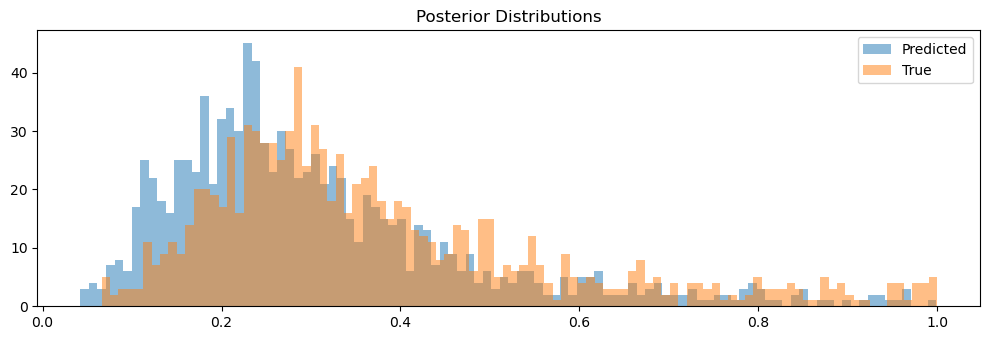

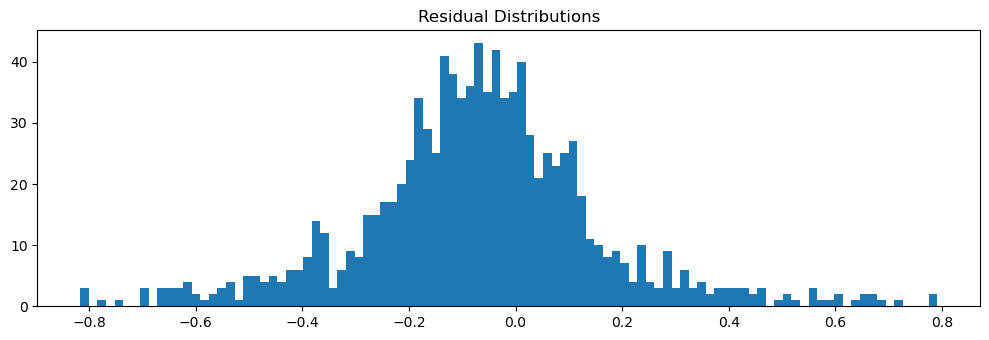

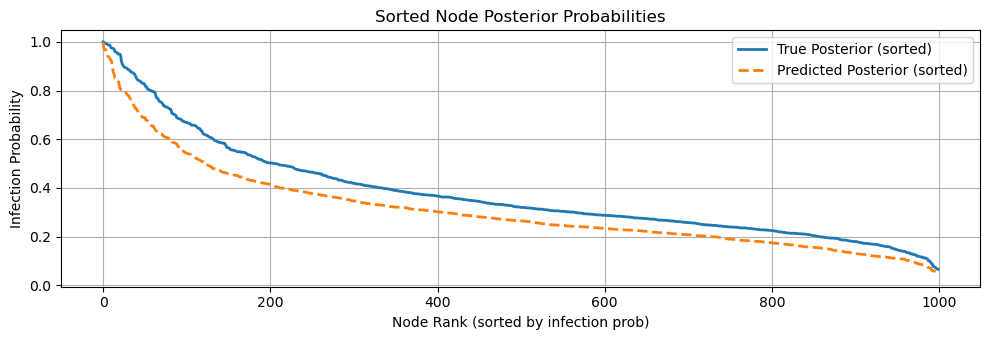

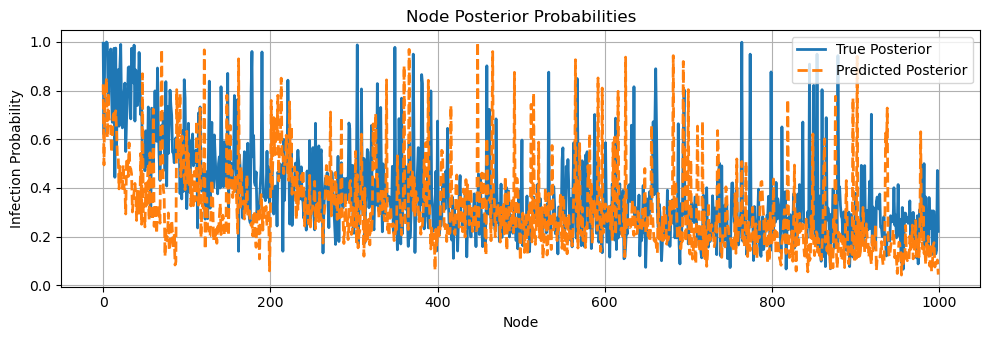

ROC threshold for 50-percentil is 0.3205000013113022


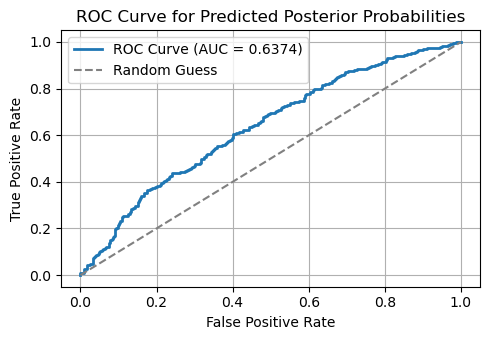

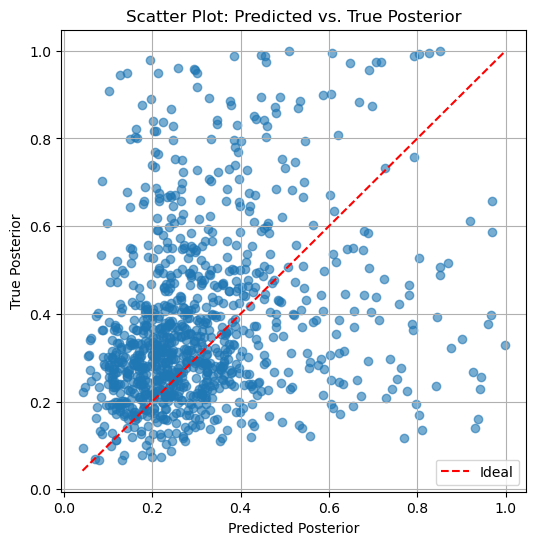

The Pearson correlation:  tensor(0.2572)
The Spearman correlation:  0.2808108334455614


In [5]:
start = time.time()
preds = IC_approx_vectorized(G_t, edge_dict_t, prior_probs_t,5)
preds_IC_approx = torch.tensor(preds, dtype=torch.float32).unsqueeze(1)
end = time.time()
print(f"Runtime: {end - start:.6f} seconds")
rmse_loss_IC_approx = torch.nn.MSELoss()(preds_IC_approx, true_posterior_tensor)
print(f"ALE Test RMSE Loss: {rmse_loss_IC_approx.item()**0.5:.4f}")
posterior_plots(size_x,
                size_y,
                preds_IC_approx,
                true_posterior_tensor_t)

Runtime: 0.157152 seconds
ALE Test RMSE Loss: 0.2518


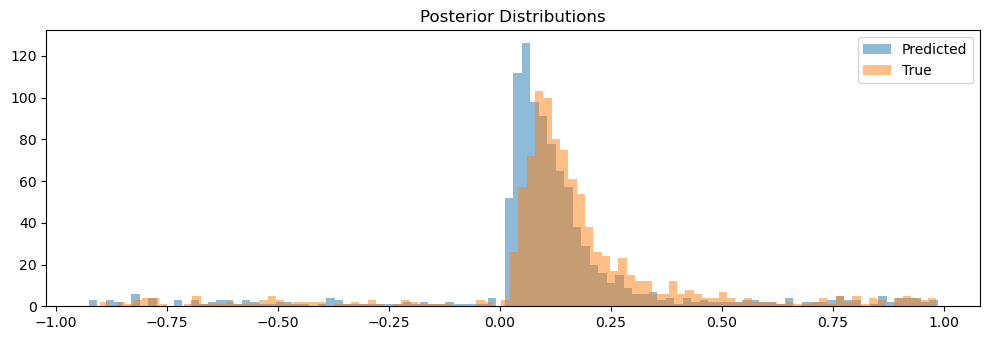

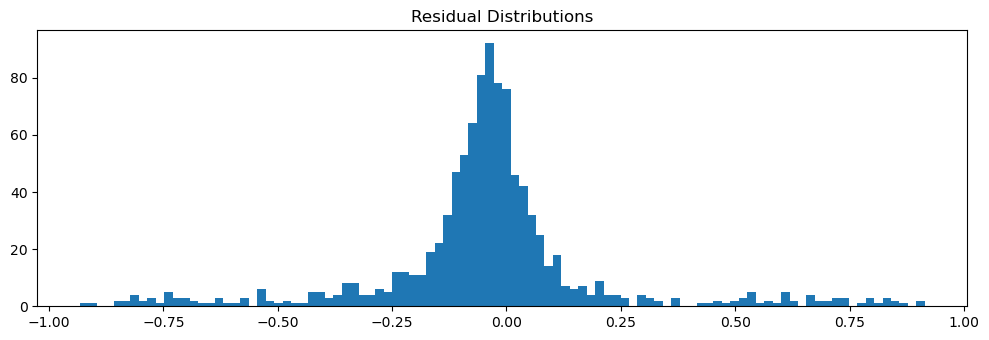

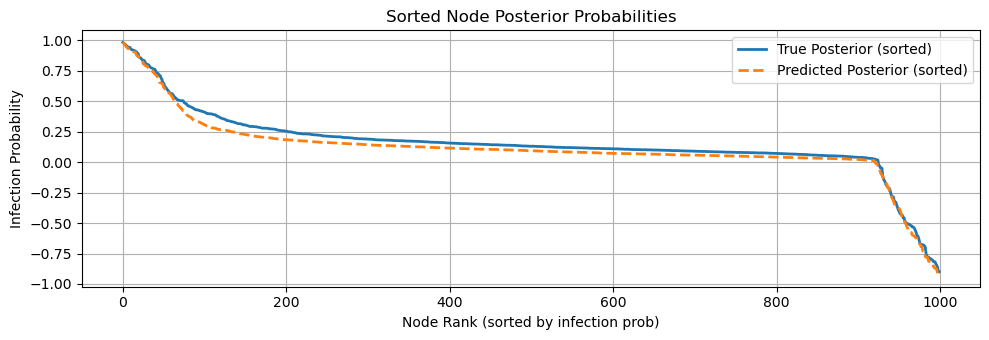

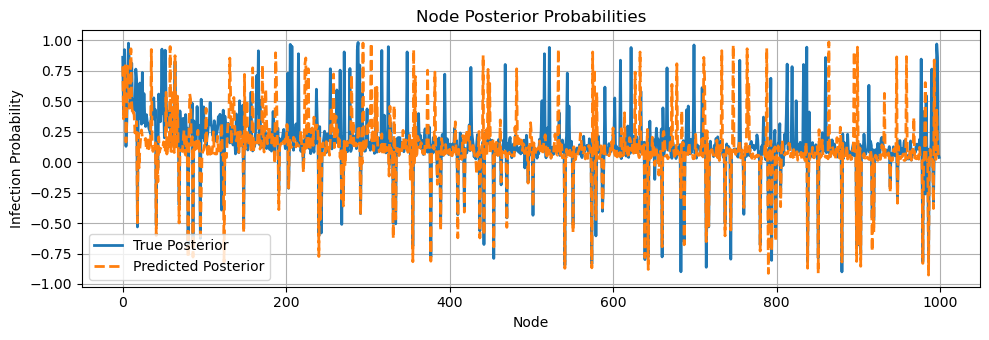

ROC threshold for 50-percentil is 0.13099999725818634


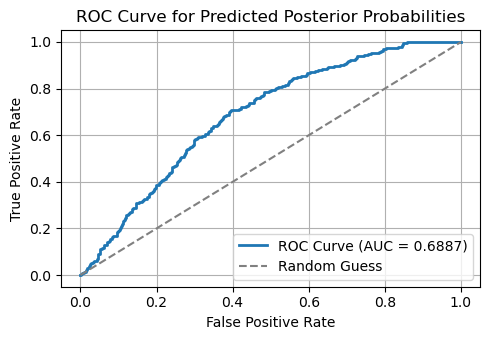

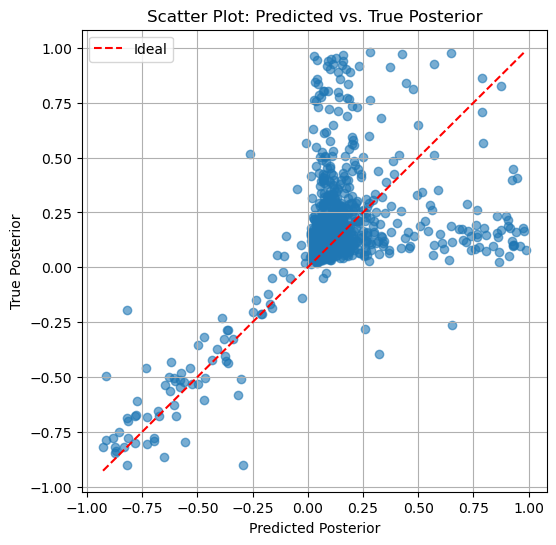

The Pearson correlation:  tensor(0.5649)
The Spearman correlation:  0.41766659224942576


In [15]:
start = time.time()
preds_IC_approx = torch.tensor(
    dmp_ic(G_t, np.array(prior_probs_t), edge_dict_t,6),
    dtype=torch.float32).unsqueeze(1)
end = time.time()
print(f"Runtime: {end - start:.6f} seconds")
rmse_loss_IC_approx = torch.nn.MSELoss()(preds_IC_approx, true_posterior_tensor)
print(f"ALE Test RMSE Loss: {rmse_loss_IC_approx.item()**0.5:.4f}")
posterior_plots(size_x,
                size_y,
                preds_IC_approx-prior_probs_t.unsqueeze(1),
                true_posterior_tensor-prior_probs_t.unsqueeze(1))

In [6]:
for name, param in trained_edge_gnn.state_dict().items():
    print(f"{name}:\n{param}\n")

bais:
-0.17120890319347382

edge_mlp.0.weight:
tensor([[-0.2179, -0.3376, -0.0300,  0.0062, -0.1387, -0.2004,  0.0280, -0.3235,
         -0.0818, -0.1014],
        [-0.1022, -0.0746,  0.0784,  0.1960, -0.1245,  0.2050, -0.2688, -0.2581,
         -0.0858,  0.0732],
        [-0.0955, -0.1129, -0.0239,  0.0298,  0.0300, -0.1763, -0.3095,  0.2017,
         -0.2401,  0.0240],
        [-0.2870,  0.0242, -0.1942, -0.0301,  0.3731, -0.0406, -0.1047, -0.1223,
          0.1365, -0.1264],
        [ 0.0947,  0.1127,  0.0254, -0.1954,  0.0724, -0.0156, -0.0651,  0.0870,
         -0.0762, -0.1762],
        [-0.3073, -0.1068, -0.2822, -0.2318,  0.1799, -0.0220, -0.0572, -0.0838,
         -0.2321,  0.0186],
        [ 0.3369, -0.3392, -0.2467,  0.1477, -0.1501, -0.1143,  0.0143, -0.2762,
          0.2543,  0.0403],
        [-0.1328, -0.0938, -0.0672, -0.1481,  0.6642, -0.4877, -0.1005,  0.1173,
         -0.1925,  0.1294],
        [-0.3611, -0.3670, -0.0740, -0.0561, -0.2289,  0.2480, -0.0160, -0.3086,


## Check the posteriors also with the ic model

In [82]:
edge_dict_pred = {}
ind = 0
for edge in edge_dict_t:
    edge_dict_pred[edge] = predicted_edge_probs_t[ind]
    ind = ind + 1
predicted_posterior_c = optimized_independent_cascade(G_t, prior_probs_t, edge_dict_pred, k=1000)
predicted_posterior_tensor_c = torch.tensor(
    [predicted_posterior_c[i] for i in range(num_nodes)], dtype=torch.float32
).unsqueeze(1)
rmse = torch.sqrt(torch.nn.functional.mse_loss(predicted_posterior_tensor_c-prior_probs_t.unsqueeze(1),
                                               true_posterior_tensor_t-prior_probs_t.unsqueeze(1)))
print(f"Final Test RMSE using the ic diffusion: {rmse.item():.4f}")
print(torch.corrcoef(torch.stack([predicted_posterior_tensor_c.squeeze()-prior_probs_t,
                                  true_posterior_tensor_t.squeeze()-prior_probs_t]))[0, 1])

edge_dict_pred = {}
ind = 0
for edge in edge_dict_t:
    edge_dict_pred[edge] = m
    ind = ind + 1
predicted_posterior_c = optimized_independent_cascade(G_t, prior_probs_t, edge_dict_pred, k=1000)
predicted_posterior_tensor_c = torch.tensor(
    [predicted_posterior_c[i] for i in range(num_nodes)], dtype=torch.float32
).unsqueeze(1)
rmse = torch.sqrt(torch.nn.functional.mse_loss(predicted_posterior_tensor_c-prior_probs_t.unsqueeze(1),
                                               true_posterior_tensor_t-prior_probs_t.unsqueeze(1)))
print(f"Final Test RMSE using the ic diffusion using mean edge probs: {rmse.item():.4f}")
print(torch.corrcoef(torch.stack([predicted_posterior_tensor_c.squeeze()-prior_probs_t,
                                  true_posterior_tensor_t.squeeze()-prior_probs_t]))[0, 1])

edge_dict_pred = {}
ind = 0
for edge in edge_dict_t:
    edge_dict_pred[edge] = random_edge_probs[ind]
    ind = ind + 1
predicted_posterior_c = optimized_independent_cascade(G_t, prior_probs_t, edge_dict_pred, k=1000)
predicted_posterior_tensor_c = torch.tensor(
    [predicted_posterior_c[i] for i in range(num_nodes)], dtype=torch.float32
).unsqueeze(1)
rmse = torch.sqrt(torch.nn.functional.mse_loss(predicted_posterior_tensor_c-prior_probs_t.unsqueeze(1),
                                               true_posterior_tensor_t-prior_probs_t.unsqueeze(1)))
print(f"Final Test RMSE using the ic diffusion using random edge probs: {rmse.item():.4f}")
print(torch.corrcoef(torch.stack([predicted_posterior_tensor_c.squeeze()-prior_probs_t,
                                  true_posterior_tensor_t.squeeze()-prior_probs_t]))[0, 1])


Final Test RMSE using the ic diffusion: 0.0788
tensor(0.9670)
Final Test RMSE using the ic diffusion using mean edge probs: 0.0591
tensor(0.9750)
Final Test RMSE using the ic diffusion using random edge probs: 0.1036
tensor(0.9255)


/home/matic/Documents/IMreasearch/py_scripts/diffusion_models/independent_cascade.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  for (u, v), p in edge_probs.items():
/tmp/ipykernel_391392/4053447569.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_IC_approx = torch.tensor(preds, dtype=torch.float32).unsqueeze(1)


Runtime: 0.011462 seconds
ALE Test RMSE Loss: 0.2277


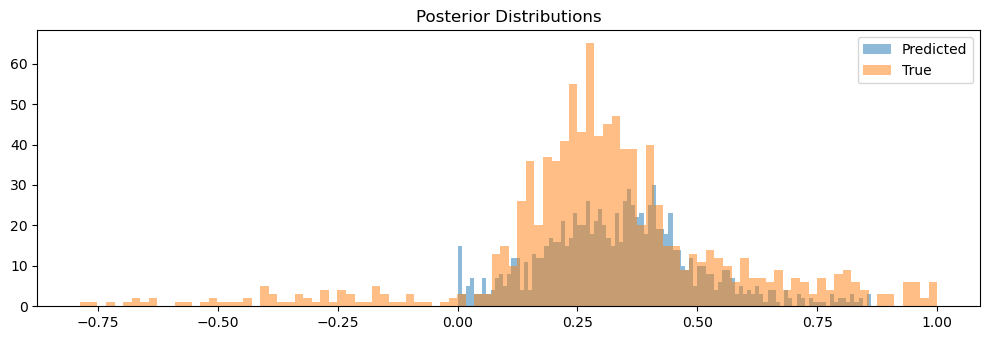

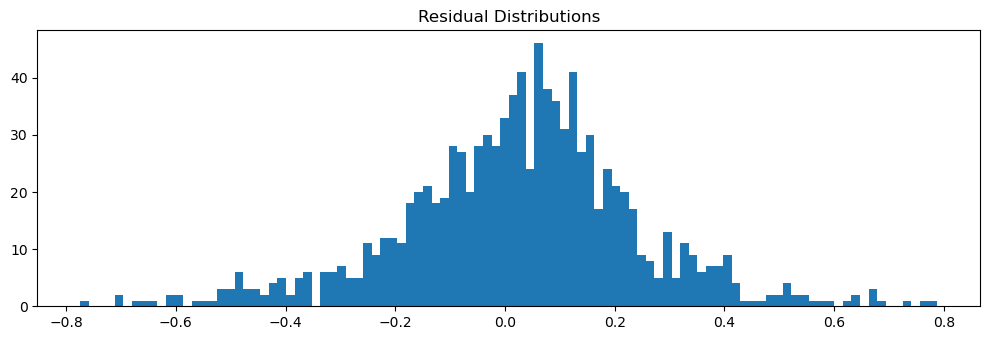

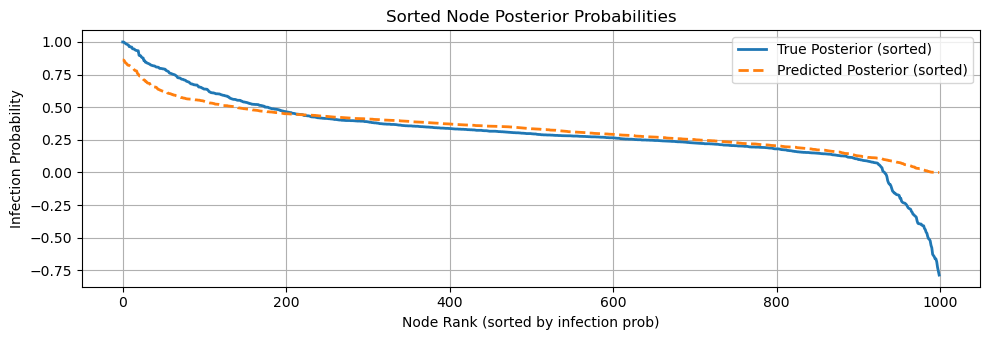

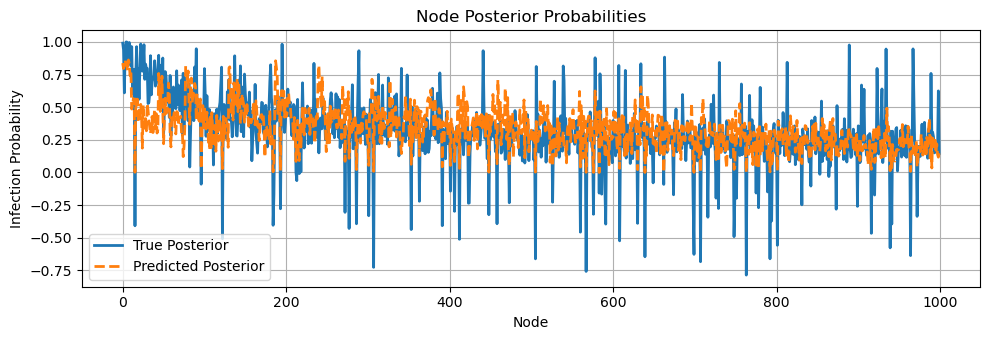

ROC threshold for 50-percentil is 0.29749999940395355


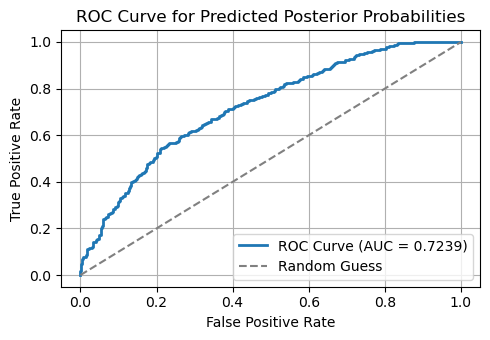

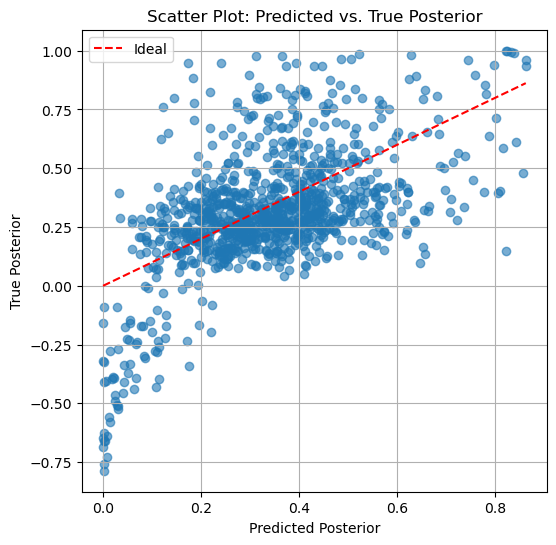

The Pearson correlation:  tensor(0.5616)
The Spearman correlation:  0.4933544646364868


In [85]:
start = time.time()
preds = IC_approx_vectorized_torch(G_t, edge_dict_pred, prior_probs_t,10)
preds_IC_approx = torch.tensor(preds, dtype=torch.float32).unsqueeze(1)
end = time.time()
print(f"Runtime: {end - start:.6f} seconds")
rmse_loss_IC_approx = torch.nn.MSELoss()(preds_IC_approx, true_posterior_tensor_t)
print(f"ALE Test RMSE Loss: {rmse_loss_IC_approx.item()**0.5:.4f}")
posterior_plots(size_x,
                size_y,
                preds_IC_approx-prior_probs_t.unsqueeze(1),
                true_posterior_tensor-prior_probs_t.unsqueeze(1))

In [8]:
predicted_edge_probs_t.mean()
edge_probs.mean()

tensor(0.1586, grad_fn=<MeanBackward0>)

## Visualizations

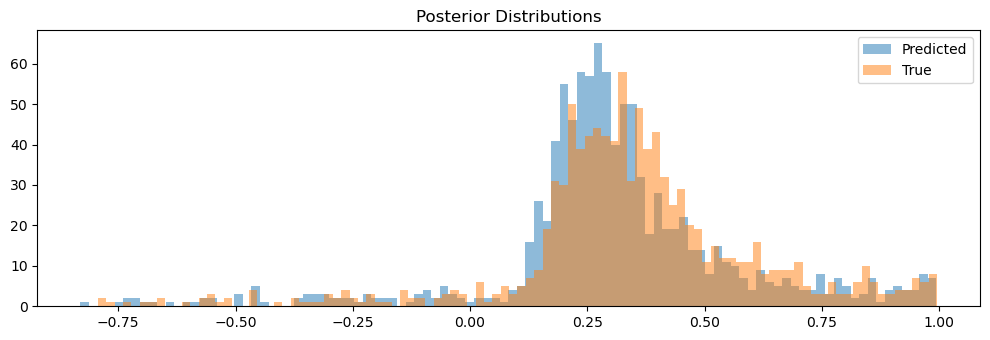

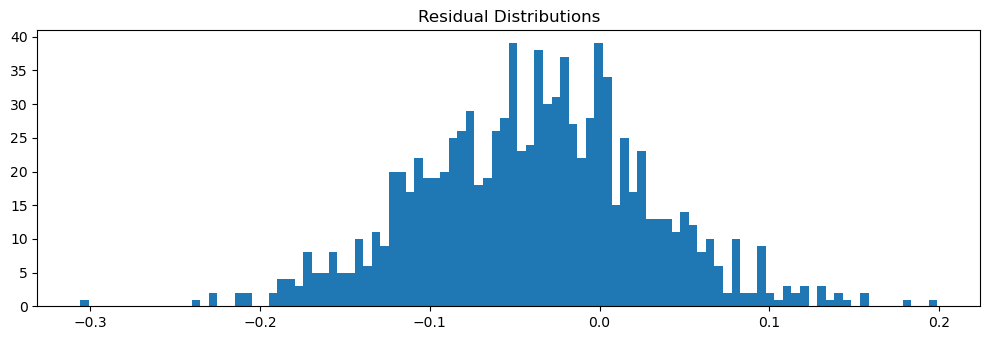

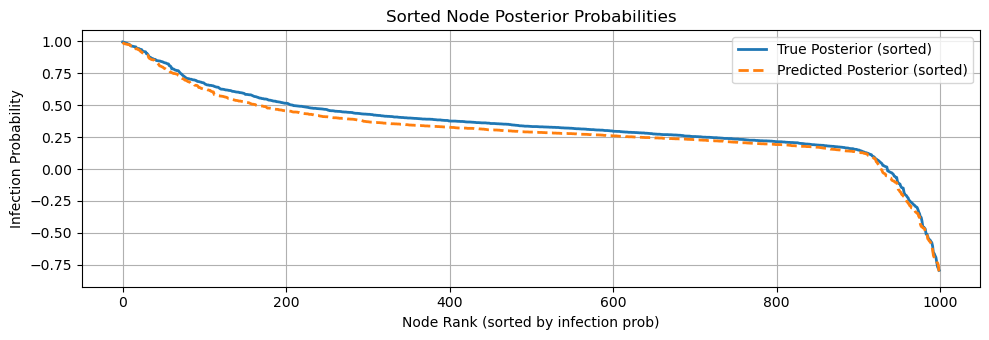

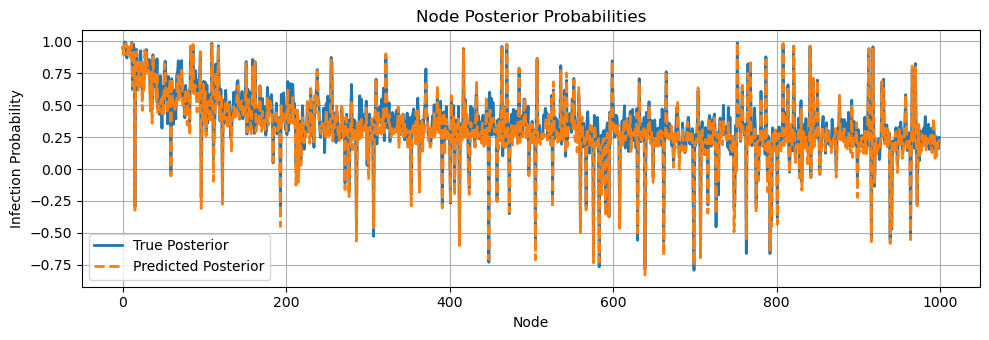

ROC threshold for 95-percentil is 0.8362000226974485


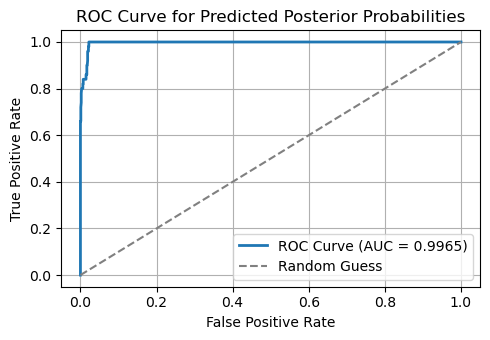

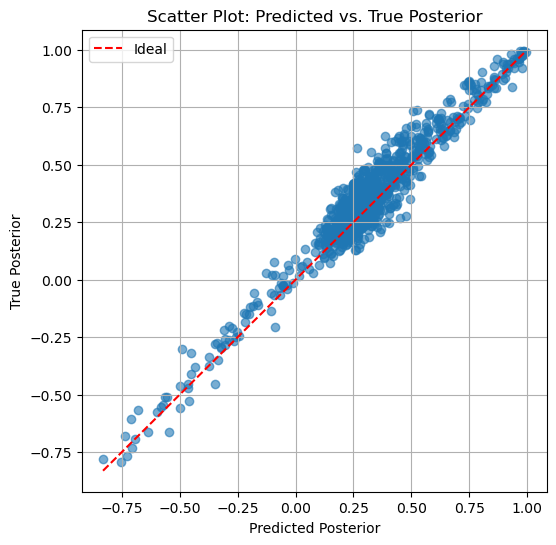

The Pearson correlation:  tensor(0.9675)
The Spearman correlation:  0.8928350887996009


In [86]:
posterior_plots(size_x,
                size_y,
                predicted_posterior_t-prior_probs_t.unsqueeze(1),
                true_posterior_tensor_t-prior_probs_t.unsqueeze(1),
               percentile=95)

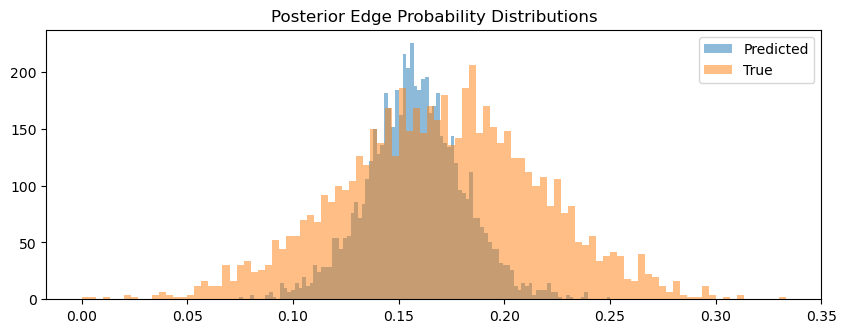

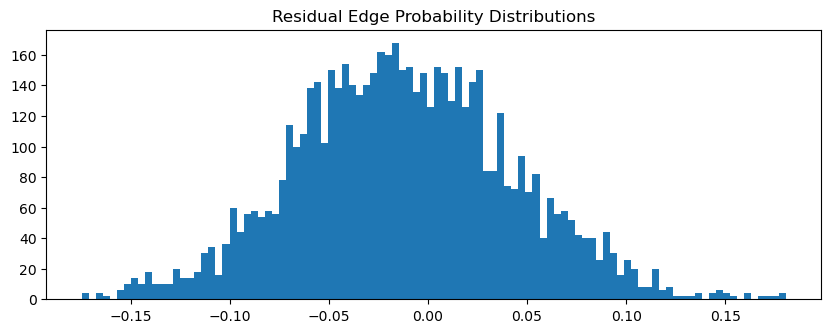

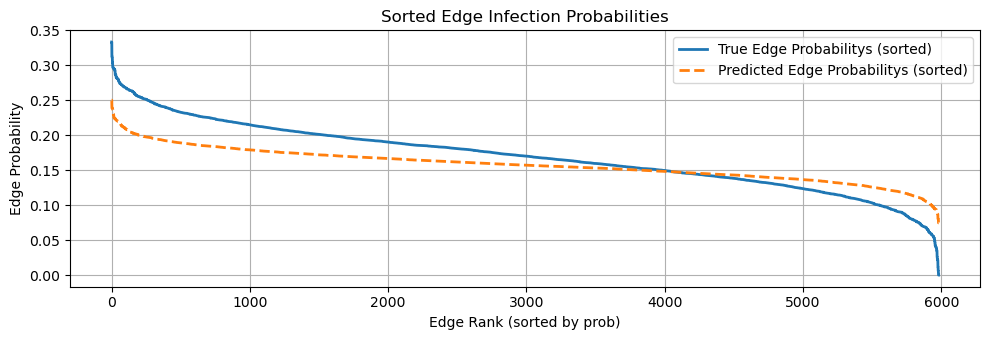

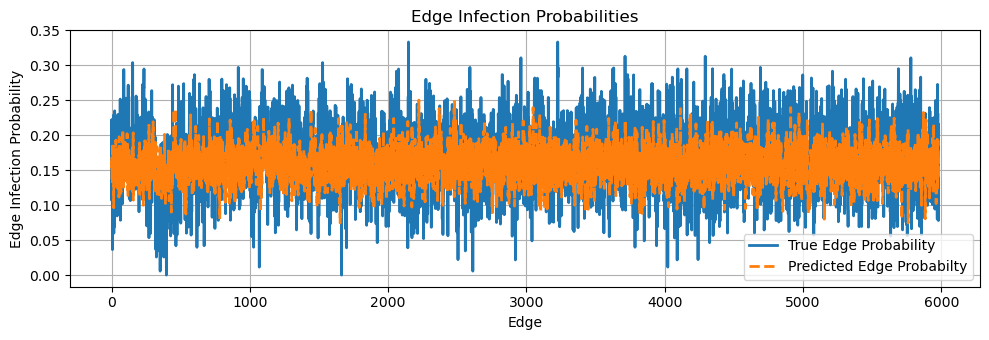

The Pearson correlation:  tensor(-0.1130, dtype=torch.float64)
The Spearman correlation:  -0.10599412971916057


In [87]:
pred_edge_probs = predicted_edge_probs_t
true_edge_probs = torch.tensor([edge_dict_t[e] for e in edge_dict_t])
edge_plots(size_x, size_y, pred_edge_probs, true_edge_probs.squeeze())

In [5]:
pred_edge_probs

tensor([0.2188, 0.1891, 0.1805,  ..., 0.2192, 0.2031, 0.1725])

In [11]:
print(torch.corrcoef(torch.stack([pred_edge_probs, true_edge_probs.squeeze()])))

tensor([[ 1.0000, -0.3684],
        [-0.3684,  1.0000]], dtype=torch.float64)


In [7]:
true_edge_probs = (true_edge_probs-true_edge_probs.mean())/(true_edge_probs.std())
pred_edge_probs = (pred_edge_probs-pred_edge_probs.mean())/pred_edge_probs.std()

In [10]:
cor = torch.corrcoef(torch.stack([true_edge_probs,
                                  pred_edge_probs]))
print(cor)

tensor([[ 1.0000, -0.3684],
        [-0.3684,  1.0000]], dtype=torch.float64)


# Double prediction

In [11]:
for n in G_t.nodes():
    G_t.nodes[n]['features'][0] = true_posterior_tensor_t.squeeze()[n]

prior_probs_t2 = true_posterior_tensor_t.squeeze()
true_posteriors_t2 = optimized_independent_cascade(G_t, prior_probs_t2, edge_dict_t, k=1000)

pred_edge_dict_t = {}
for idx, edge in enumerate(edge_dict_t):
    pred_edge_dict_t[edge] = predicted_edge_probs[idx]

predicted_posteriors_t2 = optimized_independent_cascade(G_t, prior_probs_t2, pred_edge_dict_t, k=1000)

true_posterior_tensor_t2 = torch.tensor(
    [true_posteriors_t2[i] for i in range(num_nodes)], dtype=torch.float32
).unsqueeze(1)
predicted_posterior_tensor_t2 = torch.tensor(
    [predicted_posteriors_t2[i] for i in range(num_nodes)], dtype=torch.float32
).unsqueeze(1)
posterior_plots(size_x,
                size_y,
                predicted_posterior_tensor_t2-prior_probs_t2.unsqueeze(1),
                true_posterior_tensor_t2-prior_probs_t2.unsqueeze(1))

KeyboardInterrupt: 

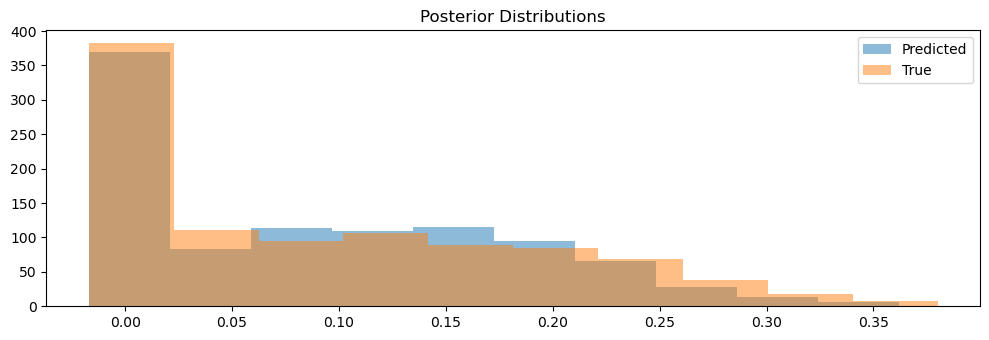

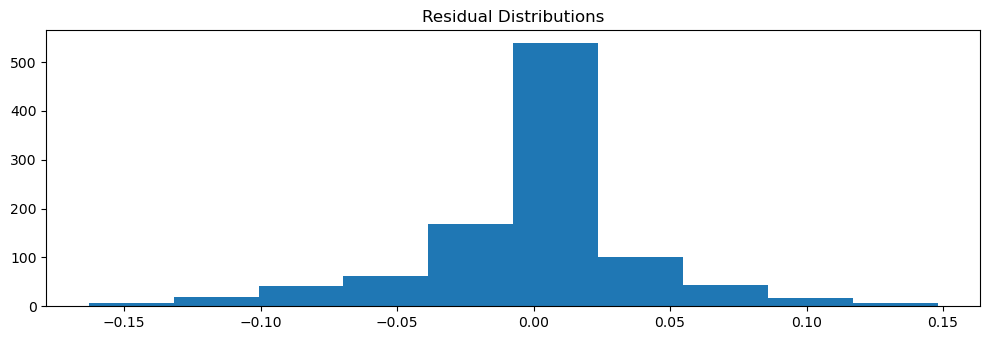

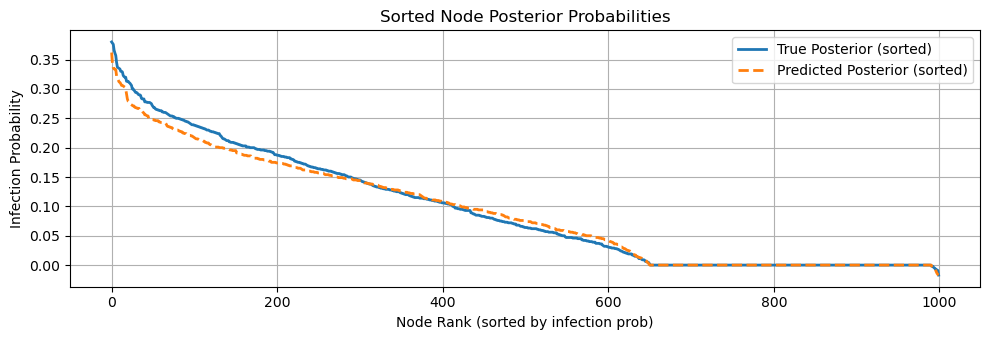

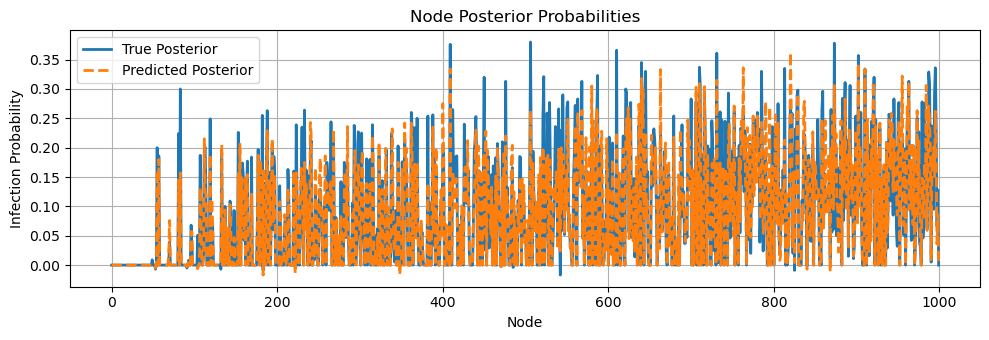

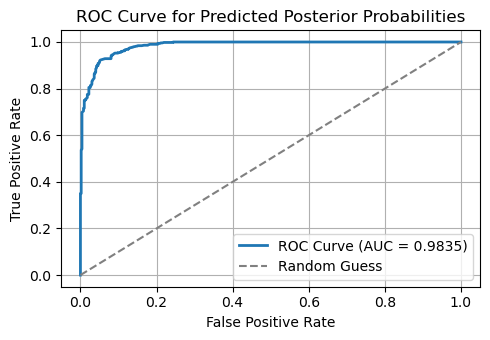

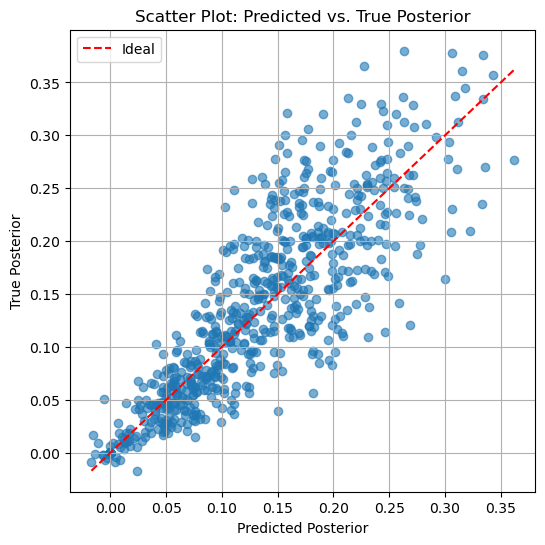

The Pearson correlation:  tensor(0.9138)
The Spearman correlation:  0.9477485337255559


In [65]:
m_edge_dict_t = {}
m=torch.tensor([edge_dict_t[t] for t in edge_dict_t]).mean()
for idx, edge in enumerate(edge_dict_t):
    m_edge_dict_t[edge] = m

predicted_posteriors_m_t2 = optimized_independent_cascade(G_t, prior_probs_t2, m_edge_dict_t, k=1000)

predicted_posterior_m_tensor_t2 = torch.tensor(
    [predicted_posteriors_m_t2[i] for i in range(num_nodes)], dtype=torch.float32
).unsqueeze(1)
posterior_plots(size_x,
                size_y,
                predicted_posterior_m_tensor_t2-prior_probs_t2.unsqueeze(1),
                true_posterior_tensor_t2-prior_probs_t2.unsqueeze(1))

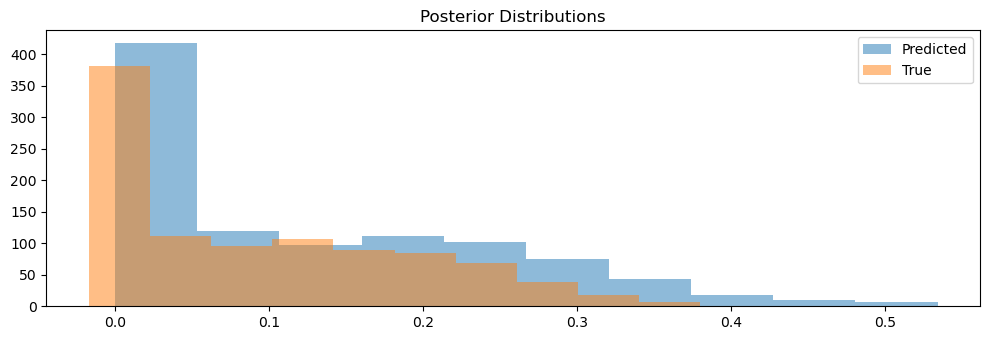

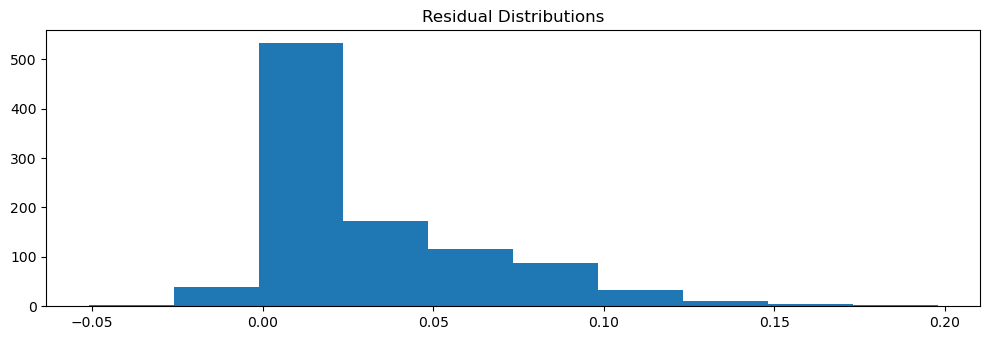

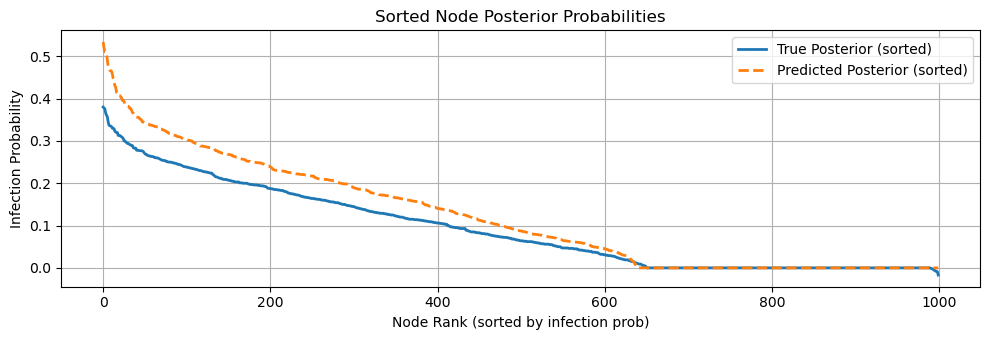

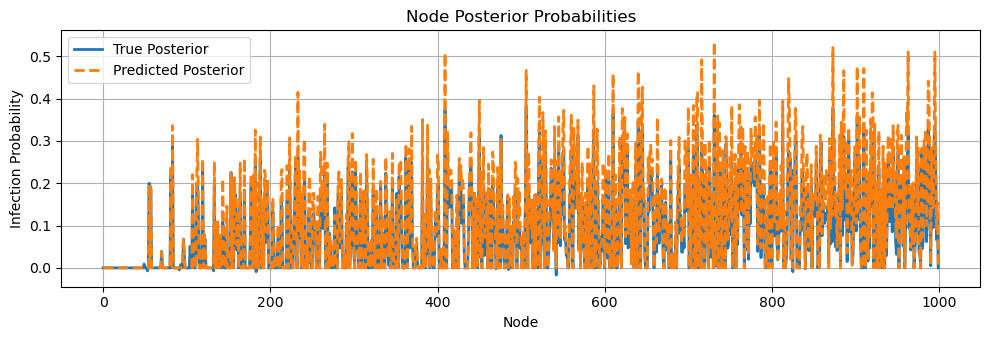

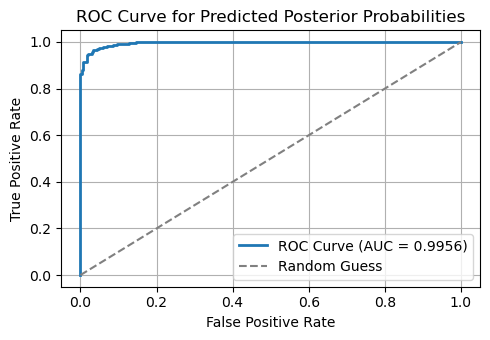

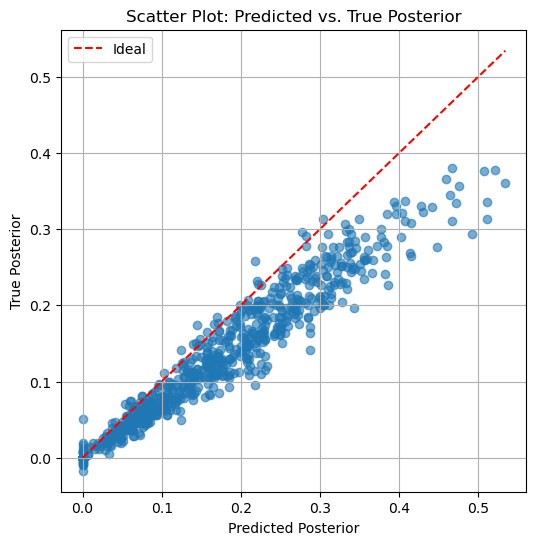

The Pearson correlation:  tensor(0.9795)
The Spearman correlation:  0.9835002774190258


In [66]:
model_posteriors_t2=diffusion_gnn(prior_probs_t2.unsqueeze(1), data_t.edge_index, predicted_edge_probs_t.unsqueeze(1))
posterior_plots(size_x,
                size_y,
                model_posteriors_t2-prior_probs_t2.unsqueeze(1),
                true_posterior_tensor_t2-prior_probs_t2.unsqueeze(1))

## GA

In [2]:
num_nodes=1000
edge_prob=0.1
prob_selected = 0.1
num_edges_per_node=3
num_node_features=5
num_edge_features=5
attribute_distribution="normal"
#edge_method='weighted_sum'
# good hyper-parameters for ModifiedALE: lr=0.001, epochs=700
max_edge=1/3
normal = False
if normal:
    node_weights=np.random.normal(size=num_node_features)
    node_weights_source=np.random.normal(size=num_node_features)
    node_weights_sink=np.random.normal(size=num_node_features)
    epsilon=np.random.normal(size=1)*-4
    edge_weights=np.random.normal(size=num_edge_features)
else:
    node_weights=np.random.rand(num_node_features)*2-1
    node_weights_source=np.random.rand(num_node_features)*2-1
    node_weights_sink=np.random.rand(num_node_features)*2-1
    epsilon=np.random.rand(1)*-4
    edge_weights=np.random.rand(num_edge_features)*2-1
# ---- 1. Setup ----
num_nodes=1000
alpha = 1
b_s=1
b_t=0.5
b_e=1
edge_method='weighted_sum'
num_sim=1000
dropout=0.3
#edge_prob=0.1
#num_edges_per_node=3
#num_node_features=5
#num_edge_features=5
#max_edge=1
#node_weights=np.random.rand(num_node_features)
#edge_weights=np.random.rand(num_edge_features)
'''G, prior_probs, edge_dict = generate_erdos_renyi_attribute_graph(num_nodes,
                                                                edge_prob,
                                                                num_node_features=num_node_features,
                                                                num_edge_features=num_edge_features,
                                                                node_weights=node_weights,
                                                                edge_weights=edge_weights,
                                                                edge_method='weighted_sum')'''
G, prior_probs,edge_dict = generate_barabasi_albert_attribute_graph(num_nodes,
                                                                    num_edges_per_node,
                                                                    num_node_features=num_node_features,
                                                                    num_edge_features=num_edge_features,
                                                                    node_weights=node_weights,
                                                                    edge_weights=edge_weights,
                                                                    edge_method=edge_method,
                                                                    max_edge=max_edge,
                                                                    prob_selected=prob_selected,
                                                                    node_weights_source=node_weights_source,
                                                                    node_weights_sink=node_weights_sink,
                                                                    epsilon=epsilon,
                                                                    b_s=b_s,
                                                                    b_t=b_t,
                                                                    b_e=b_e,
                                                                    attribute_distribution=attribute_distribution,
                                                                    max_node_features=0.5)

'''G_t, prior_probs_t, edge_dict_t = generate_erdos_renyi_attribute_graph(num_nodes,
                                                                edge_prob,
                                                                num_node_features=num_node_features,
                                                                num_edge_features=num_edge_features,
                                                                node_weights=node_weights,
                                                                edge_weights=edge_weights,
                                                                edge_method='weighted_sum')'''
G_t, prior_probs_t, edge_dict_t = generate_barabasi_albert_attribute_graph(num_nodes,
                                                                        num_edges_per_node,
                                                                        num_node_features=num_node_features,
                                                                        num_edge_features=num_edge_features,
                                                                        node_weights=node_weights,
                                                                        edge_weights=edge_weights,
                                                                        edge_method=edge_method,
                                                                        max_edge=max_edge,
                                                                        prob_selected=prob_selected,
                                                                        node_weights_source=node_weights_source,
                                                                        node_weights_sink=node_weights_sink,
                                                                        epsilon=epsilon,
                                                                        b_s=b_s,
                                                                        b_t=b_t,
                                                                        b_e=b_e,
                                                                        attribute_distribution=attribute_distribution,
                                                                        max_node_features=0.5)

# Generate edge index and edge features
edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
edge_index_t = torch.tensor(list(G_t.edges), dtype=torch.long).t().contiguous()

edge_attr = torch.tensor(np.array([G.edges[e]['features'] for e in G.edges()]), dtype=torch.float)
edge_attr_t = torch.tensor(np.array([G_t.edges[e]['features'] for e in G_t.edges()]), dtype=torch.float)

edges = list(G.edges())
edges_t = list(G_t.edges())

edge_probs = torch.tensor([edge_dict[(u, v)] for (u, v) in edge_dict], dtype=torch.float)
edge_probs_t = torch.tensor([edge_dict_t[(u, v)] for (u, v) in edge_dict_t], dtype=torch.float)

node_features = torch.tensor(
    [G.nodes[node]['features'] for node in G.nodes()],
    dtype=torch.float32
)
node_features_t = torch.tensor(
    [G_t.nodes[node]['features'] for node in G_t.nodes()],
    dtype=torch.float32
)

# Create PyTorch Geometric Data object
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
data_for_diff = {
    "G" : G,
    "prior_probs" : prior_probs,
    "edge_dict" : edge_dict,
    "k" : 10
}
data_t = Data(x=node_features_t, edge_index=edge_index_t, edge_attr=edge_attr_t)
# ---- 2. Generate True Posteriors with IC ----
true_posteriors = optimized_independent_cascade(G, prior_probs, edge_dict, k=1000)
true_posteriors_t = optimized_independent_cascade(G_t, prior_probs_t, edge_dict_t, k=1000)
true_posterior_tensor = torch.tensor(
    [true_posteriors[i] for i in range(num_nodes)], dtype=torch.float32
).unsqueeze(1)
true_posterior_tensor_t = torch.tensor(
    [true_posteriors_t[i] for i in range(num_nodes)], dtype=torch.float32
).unsqueeze(1)

/tmp/ipykernel_247074/2307855596.py:103: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  node_features = torch.tensor(


In [3]:
best_weights = run_ga_training(
    G=G,
    data=data,
    edge_dict=edge_dict,
    true_posterior_tensor=true_posterior_tensor,
    generations=100  # You can tune this
)

Generation 0, Loss: 0.1020
Generation 10, Loss: 0.0920
Generation 20, Loss: 0.0896
Generation 30, Loss: 0.0871
Generation 40, Loss: 0.0841


KeyboardInterrupt: 

In [4]:
evaluate_on_test_graph(
    G_t=G_t,
    data_t=data_t,
    best_w=best_weights,
    true_posterior_tensor_t=true_posterior_tensor_t
)

Test RMSE (GA model): 0.3475


In [126]:
def edge_pred(true_posterior_tensor, G, prior_probs, T, initial_guess=None, tol = 0.001, max_iter=10, lr=0.001):
    edge_dict = {}
    if initial_guess is not None:
        edge_dict = initial_guess
    else:
        for edge in G.edges():
            edge_dict[edge] = 0.5
    for _ in range(max_iter):
        pred_post = IC_approx_vectorized(G, edge_dict, prior_probs, T, 1)
        pred_post_tensor = torch.tensor(pred_post, dtype=torch.float32).unsqueeze(1)

        discrepancy = true_posterior_tensor > pred_post_tensor 
        node_disc = np.zeros(len(G.nodes()))
        for node in G.nodes():
            if discrepancy[node]:
                if (true_posterior_tensor[node]-pred_post_tensor[node]).abs() > tol:
                    node_disc[node] += (true_posterior_tensor[node]-pred_post_tensor[node]).abs()
            else:
                if (true_posterior_tensor[node]-pred_post_tensor[node]).abs() > tol:
                    node_disc[node] -= (true_posterior_tensor[node]-pred_post_tensor[node]).abs()
        for (u,v) in edge_dict:
            edge_score = node_disc[u]+node_disc[v]
            edge_dict[(u,v)] += edge_score*lr
    return edge_dict

In [131]:
G, prior_probs = generate_barabasi_albert_graph(num_nodes = 1000,
                                                    num_edges_per_node = 5,
                                                    prob_selected = 0.1)
    
edge_dict = generate_edge_probabilities(G,method="random",low=0, high=1/3)

ic = optimized_independent_cascade(G, prior_probs, edge_dict, 1000)
true_posterior_tensor = torch.tensor(
    [ic[node] for node in ic],
    dtype=torch.float
).view(-1, 1)

initial_guess = {}
for edge in edge_dict:
    initial_guess[edge] = 1/6

predicted_edge_dict = edge_pred(true_posterior_tensor,
                                G,
                                prior_probs,
                                T=5,
                                initial_guess=initial_guess,
                                tol = 0.001,
                                max_iter=100,
                                lr=0.01)

NameError: name 'intial_guess' is not defined

tensor(0.3138)


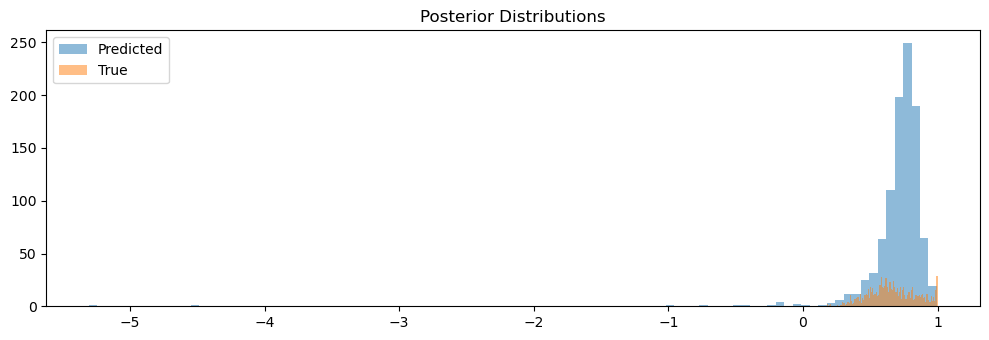

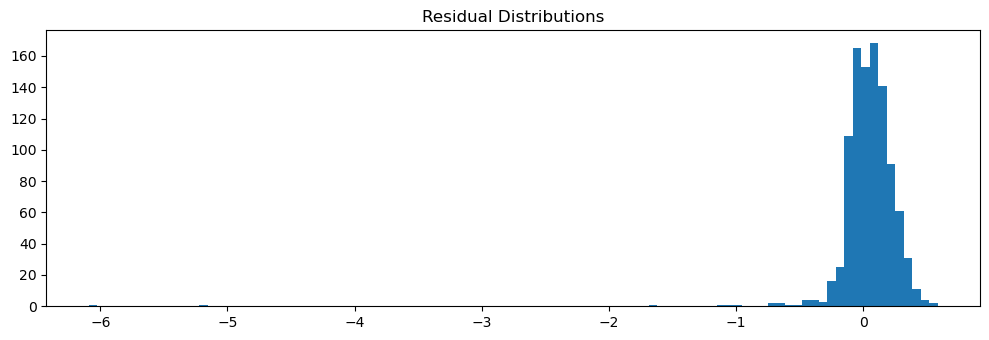

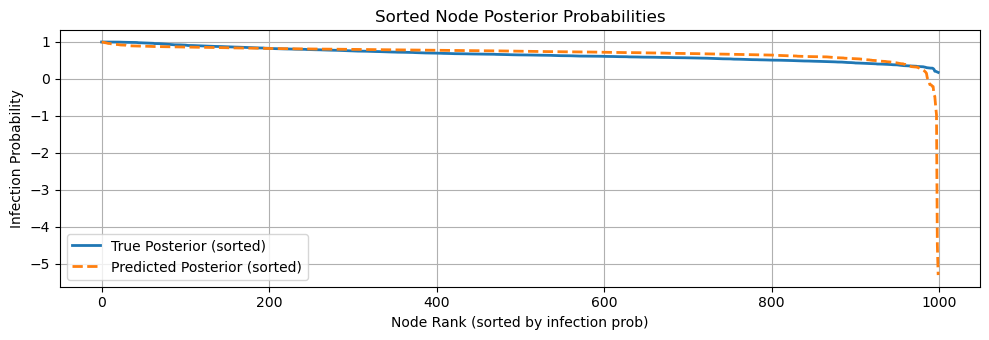

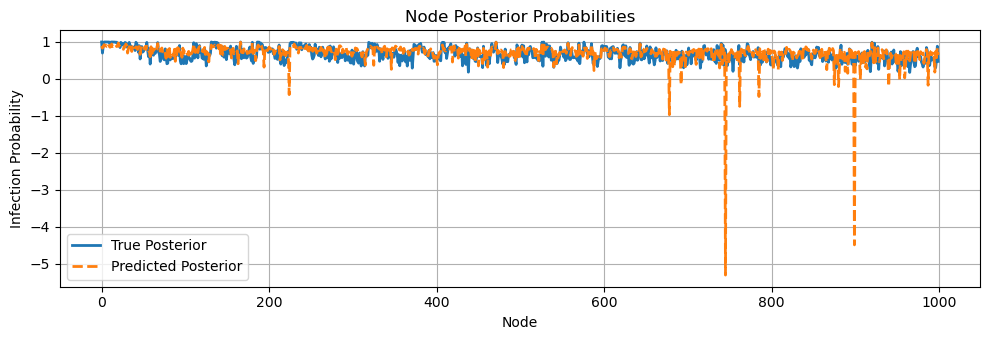

ROC threshold for 95-percentil is 0.9750000238418579


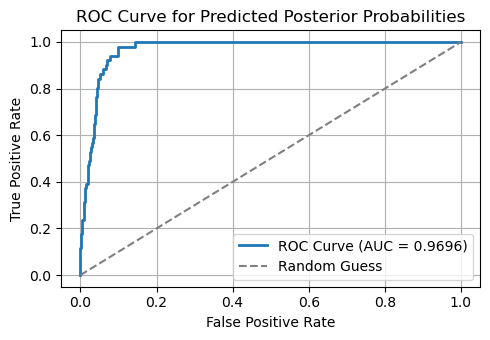

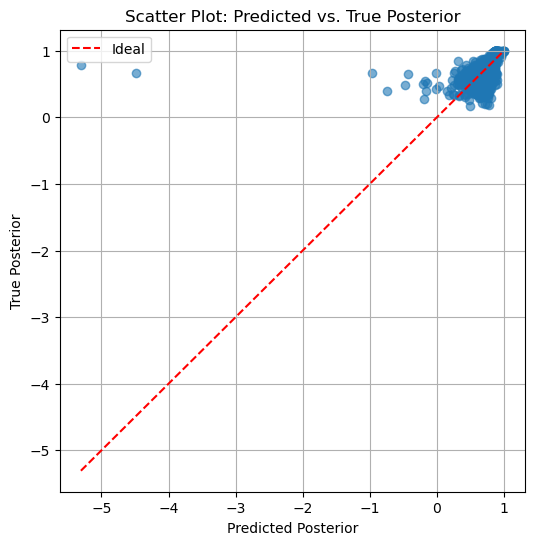

The Pearson correlation:  tensor(0.2520)
The Spearman correlation:  0.6319075881426404


In [130]:
pred_post = IC_approx_vectorized(G, predicted_edge_dict, prior_probs, 5, 1)
pred_post_tensor = torch.tensor(pred_post, dtype=torch.float32).unsqueeze(1)

print(((true_posterior_tensor-pred_post_tensor)**2).mean()**0.5)
posterior_plots(size_x,
                size_y,
                pred_post_tensor,
                true_posterior_tensor,
                percentile=95)

In [ ]:
edge_tensor = torch.tensor([edge_dict[edge]])